In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2

import numpy as np
from collections import defaultdict


from PIL import Image, ImageFilter
import io
import re
import random
import numpy.random as npr
from skimage import data
from scipy.ndimage import rotate
from kernels import *
import torchvision
from torchvision import models
import os
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset

import torchvision.transforms as transforms
 
import my_utils as ut
import old_utils_averaged_filters as old_ut_avg
import old_utils_multi_image_old_snr as old_ut_multi
from transformers import Swinv2ForImageClassification, SwinConfig
from torch.optim import AdamW
from torchvision import transforms, datasets
import test_models as mt


In [2]:
transformMultiImage = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
   
])

transformOldPre = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
   
])
# Create dataset instances
train_dataset_old_smr = old_ut_multi.DatasetAI(root_dir='/mnt/e/GenImage', transform=transformMultiImage, split='train')
val_test_dataset_old_smr  = old_ut_multi.DatasetAI(root_dir='/mnt/e/GenImage', transform=transformMultiImage, split='val')
test_dataset_old_smr = old_ut_multi.DatasetAI(root_dir='/mnt/e/GenImage', transform=transformMultiImage, split='test')

train_dataset_old_pre = old_ut_avg.DatasetAI(root_dir='/mnt/e/GenImage', transform=transformOldPre, split='train')
val_test_dataset_old_pre  = old_ut_avg.DatasetAI(root_dir='/mnt/e/GenImage', transform=transformOldPre, split='val')
test_dataset_old_pre = old_ut_avg.DatasetAI(root_dir='/mnt/e/GenImage', transform=transformOldPre, split='test')

train_dataset_new_pre = ut.DatasetAI(root_dir='/mnt/e/GenImage', transform=transformMultiImage, split='train')
val_test_dataset_new_pre  = ut.DatasetAI(root_dir='/mnt/e/GenImage', transform=transformMultiImage, split='val')
test_dataset_new_pre = ut.DatasetAI(root_dir='/mnt/e/GenImage', transform=transformMultiImage, split='test')

train_subset_old_smr ,val_subset_old_smr, test_subset_old_smr = ut.split_datasets(train_dataset_old_smr, val_test_dataset_old_smr, 8, 3750, 3750)
train_subset_old_pre ,val_subset_old_pre, test_subset_old_pre = ut.split_datasets(train_dataset_old_pre, val_test_dataset_old_pre, 8, 3750, 3750)
train_subset_new_pre ,val_subset_new_pre, test_subset_new_pre = ut.split_datasets(train_dataset_new_pre, val_test_dataset_new_pre, 8, 3750, 3750)

# Concatenate datasets for the old_smr model
test_old_smr = ConcatDataset([test_subset_old_smr, test_dataset_old_smr])

# Concatenate datasets for the old_pre model
test_old_pre = ConcatDataset([test_subset_old_pre, test_dataset_old_pre])

# Concatenate datasets for the new_pre model
test_new_pre = ConcatDataset([test_subset_new_pre, test_dataset_new_pre])

train_loader_old_smr = DataLoader(train_subset_old_smr, batch_size=32, shuffle=True, num_workers=4)
val_loader_old_smr = DataLoader(val_subset_old_smr, batch_size=32, shuffle=True, num_workers=4)
test_loader_old_smr = DataLoader(test_old_smr, batch_size=32, shuffle=True, num_workers=4)


train_loader_old_pre = DataLoader(train_subset_old_pre, batch_size=32, shuffle=True, num_workers=4)
val_loader_old_pre = DataLoader(val_subset_old_pre, batch_size=32, shuffle=True, num_workers=4)
test_loader_old_pre = DataLoader(test_old_pre, batch_size=32, shuffle=True, num_workers=4)


train_loader_new_pre = DataLoader(train_subset_new_pre, batch_size=32, shuffle=True, num_workers=4)
val_loader_new_pre = DataLoader(val_subset_new_pre, batch_size=32, shuffle=True, num_workers=4)
test_loader_new_pre = DataLoader(test_new_pre, batch_size=32, shuffle=True, num_workers=4)



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kernels = ut.apply_high_pass_filter()

model_SWIN_oldPre = mt.SwinClassificationOldest().to(device)
model_SWIN_MultiImage = mt.SwinClassification_MultiImage(kernels).to(device)

model_RESNET_oldPre = mt.ResNetClassifierOldest().to(device)
model_RESNET_MultiImage = mt.ResNetClassifier_MultiImage(kernels).to(device)

model_Original_oldPre = mt.BaseClassifierOldest().to(device)
model_Original_MultiImage = mt.BaseClassifier_MultiImage(kernels).to(device)



You are using a model of type swinv2 to instantiate a model of type swin. This is not supported for all configurations of models and can yield errors.
You are using a model of type swinv2 to instantiate a model of type swin. This is not supported for all configurations of models and can yield errors.


Old Preprocessing


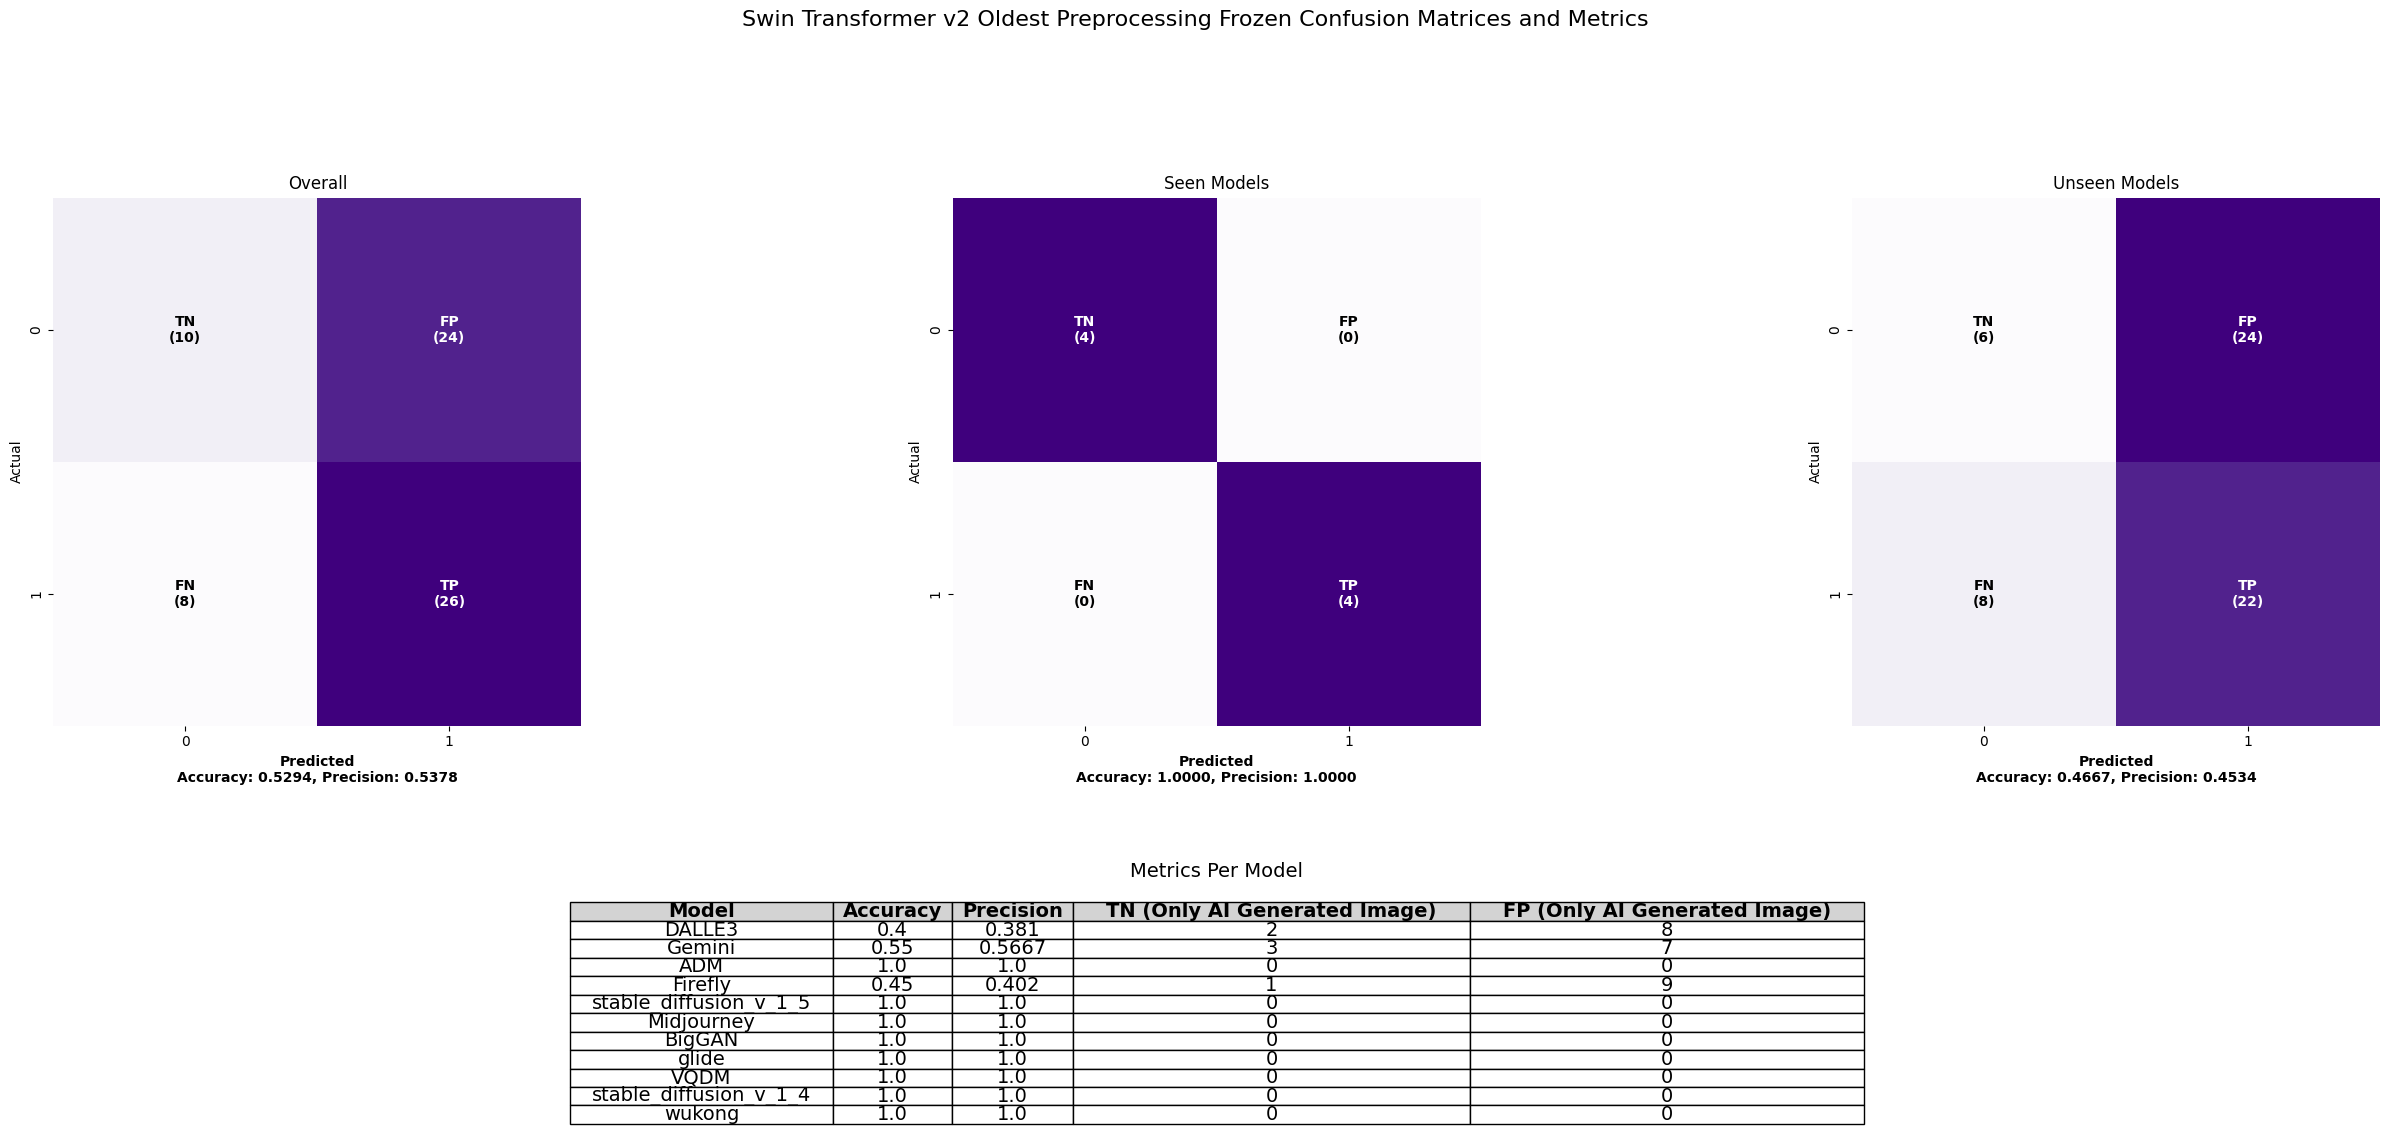

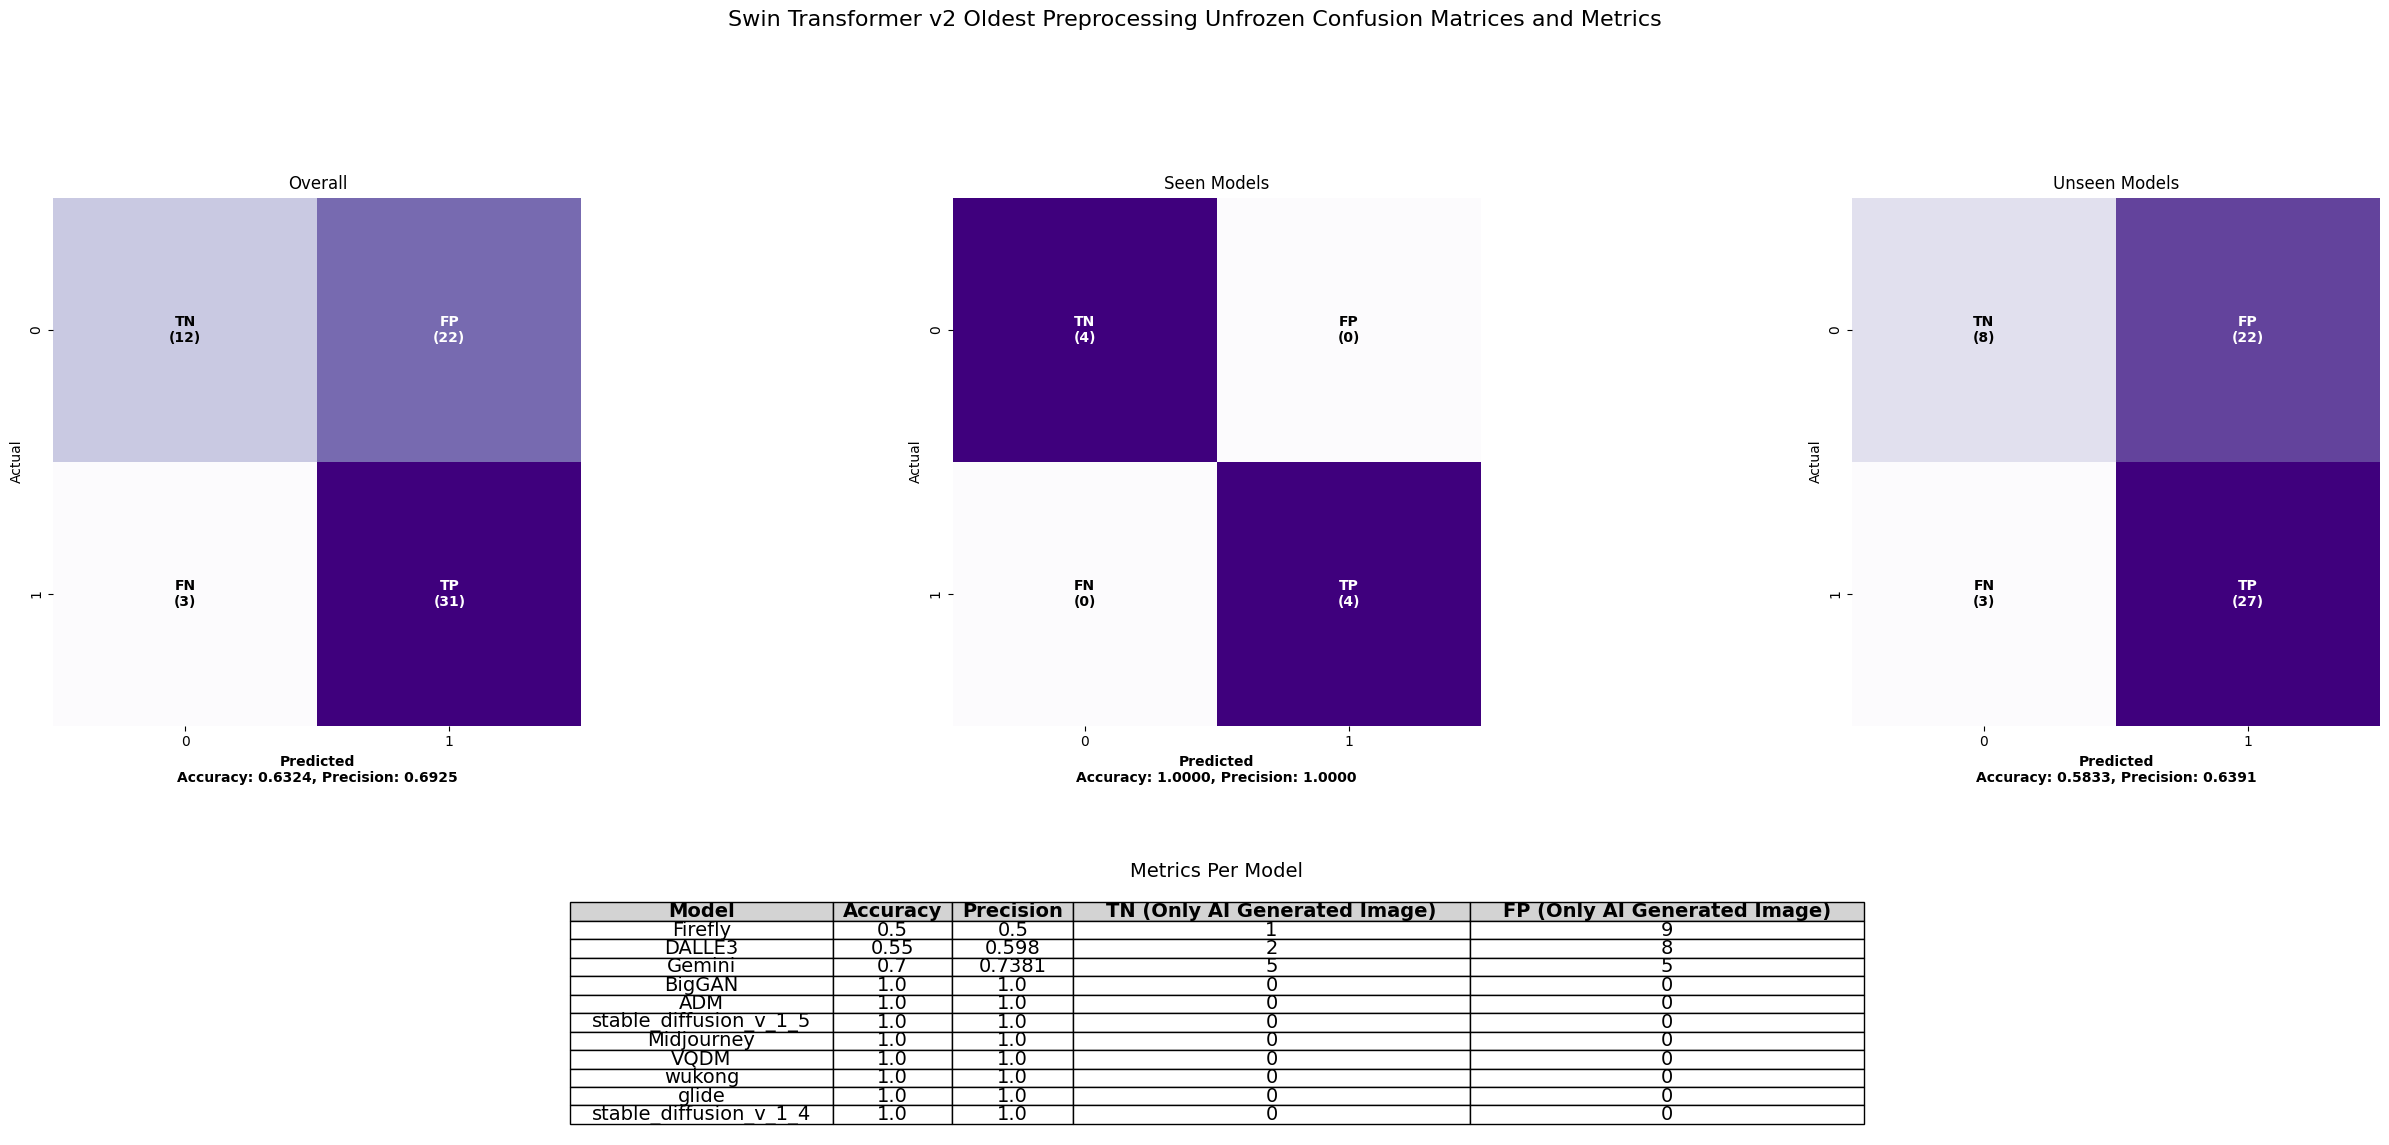

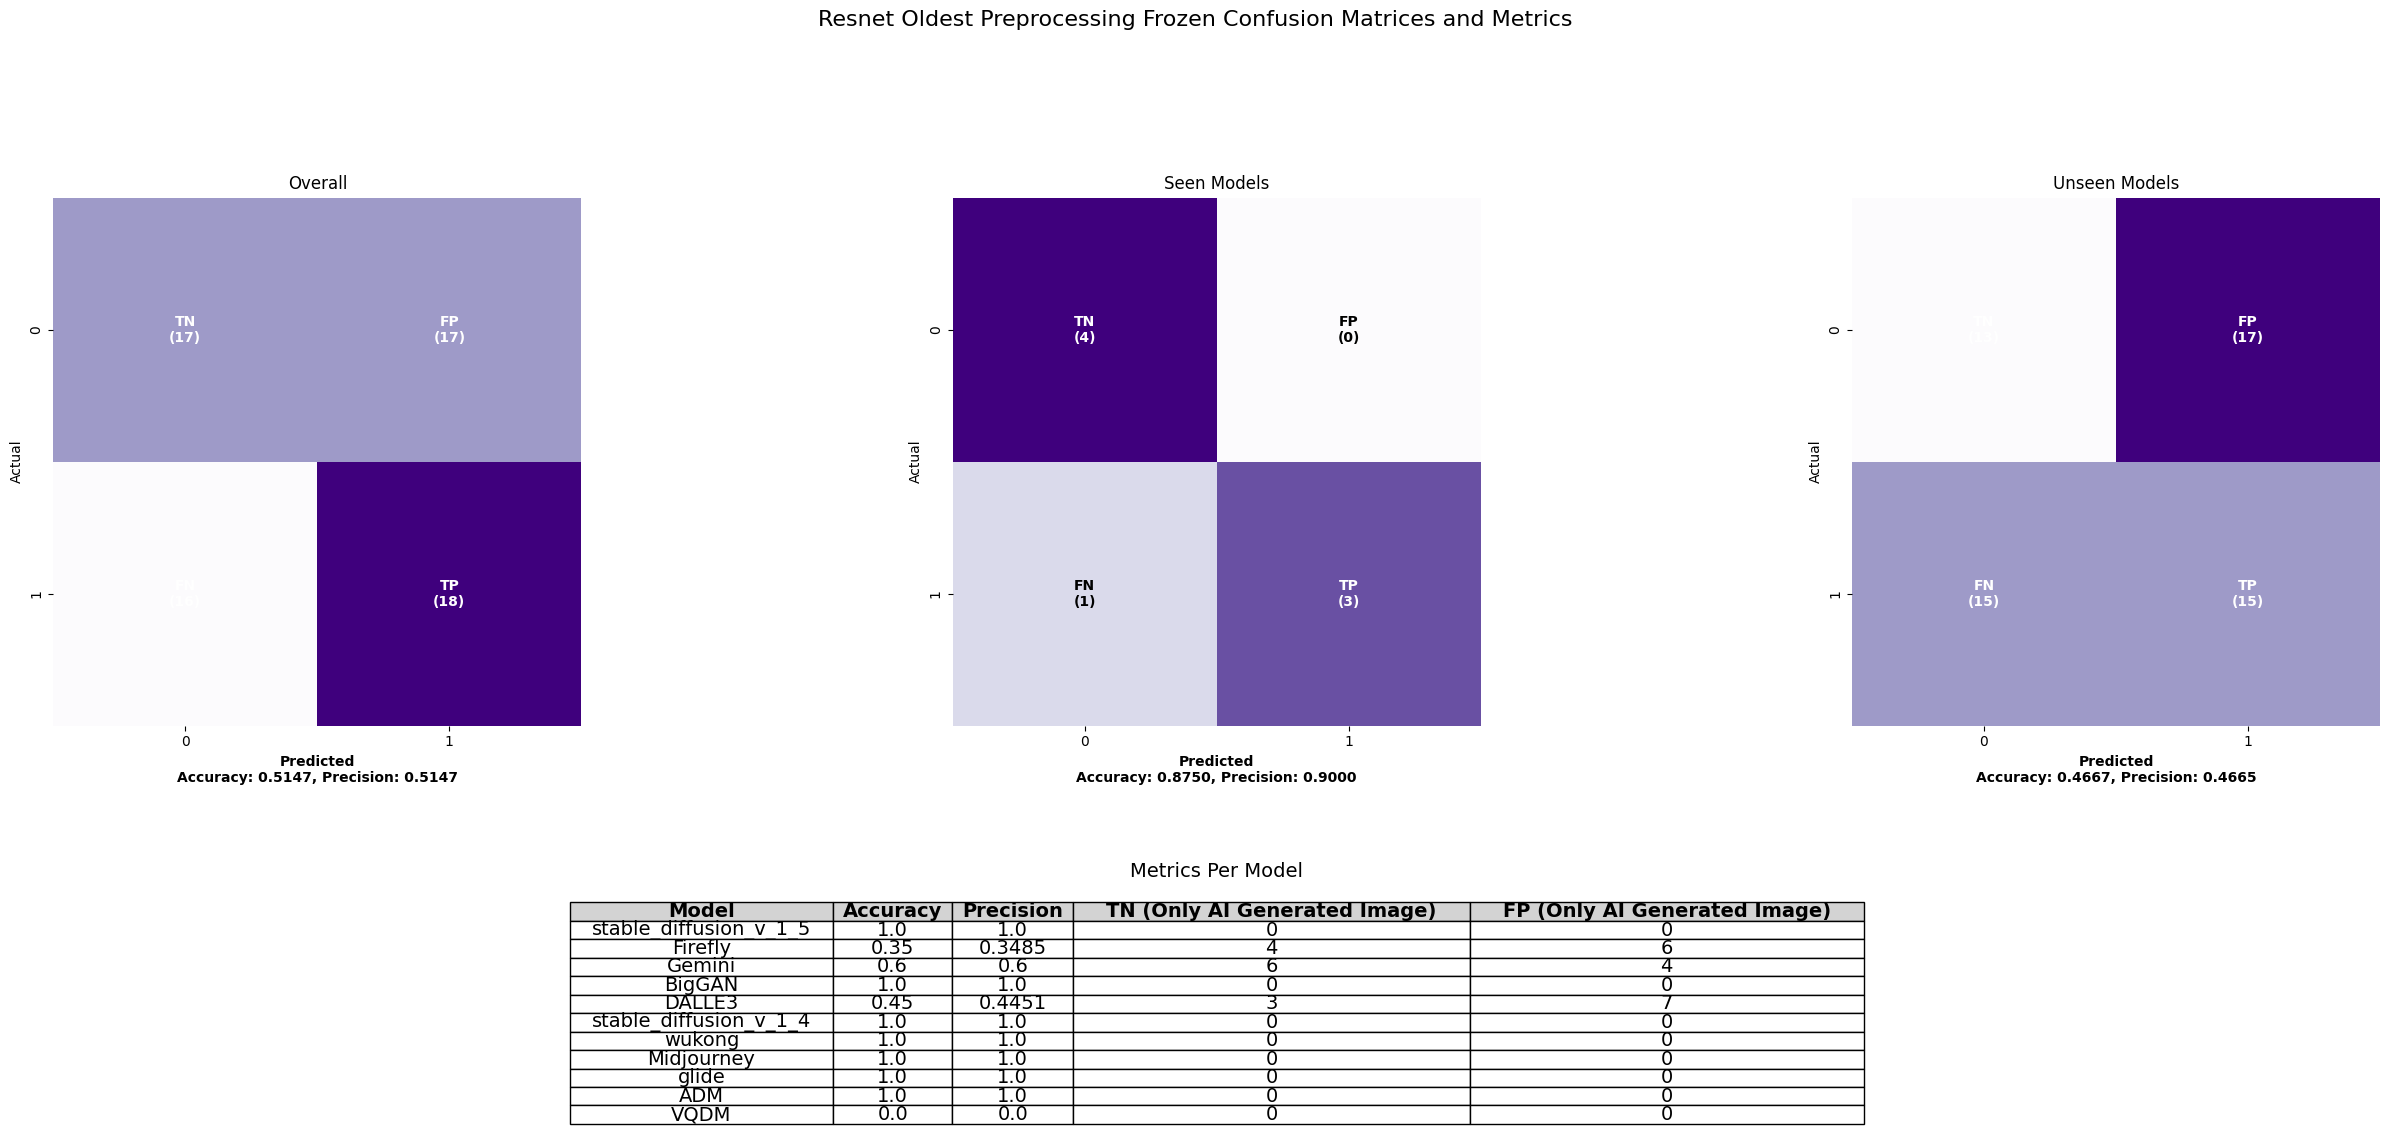

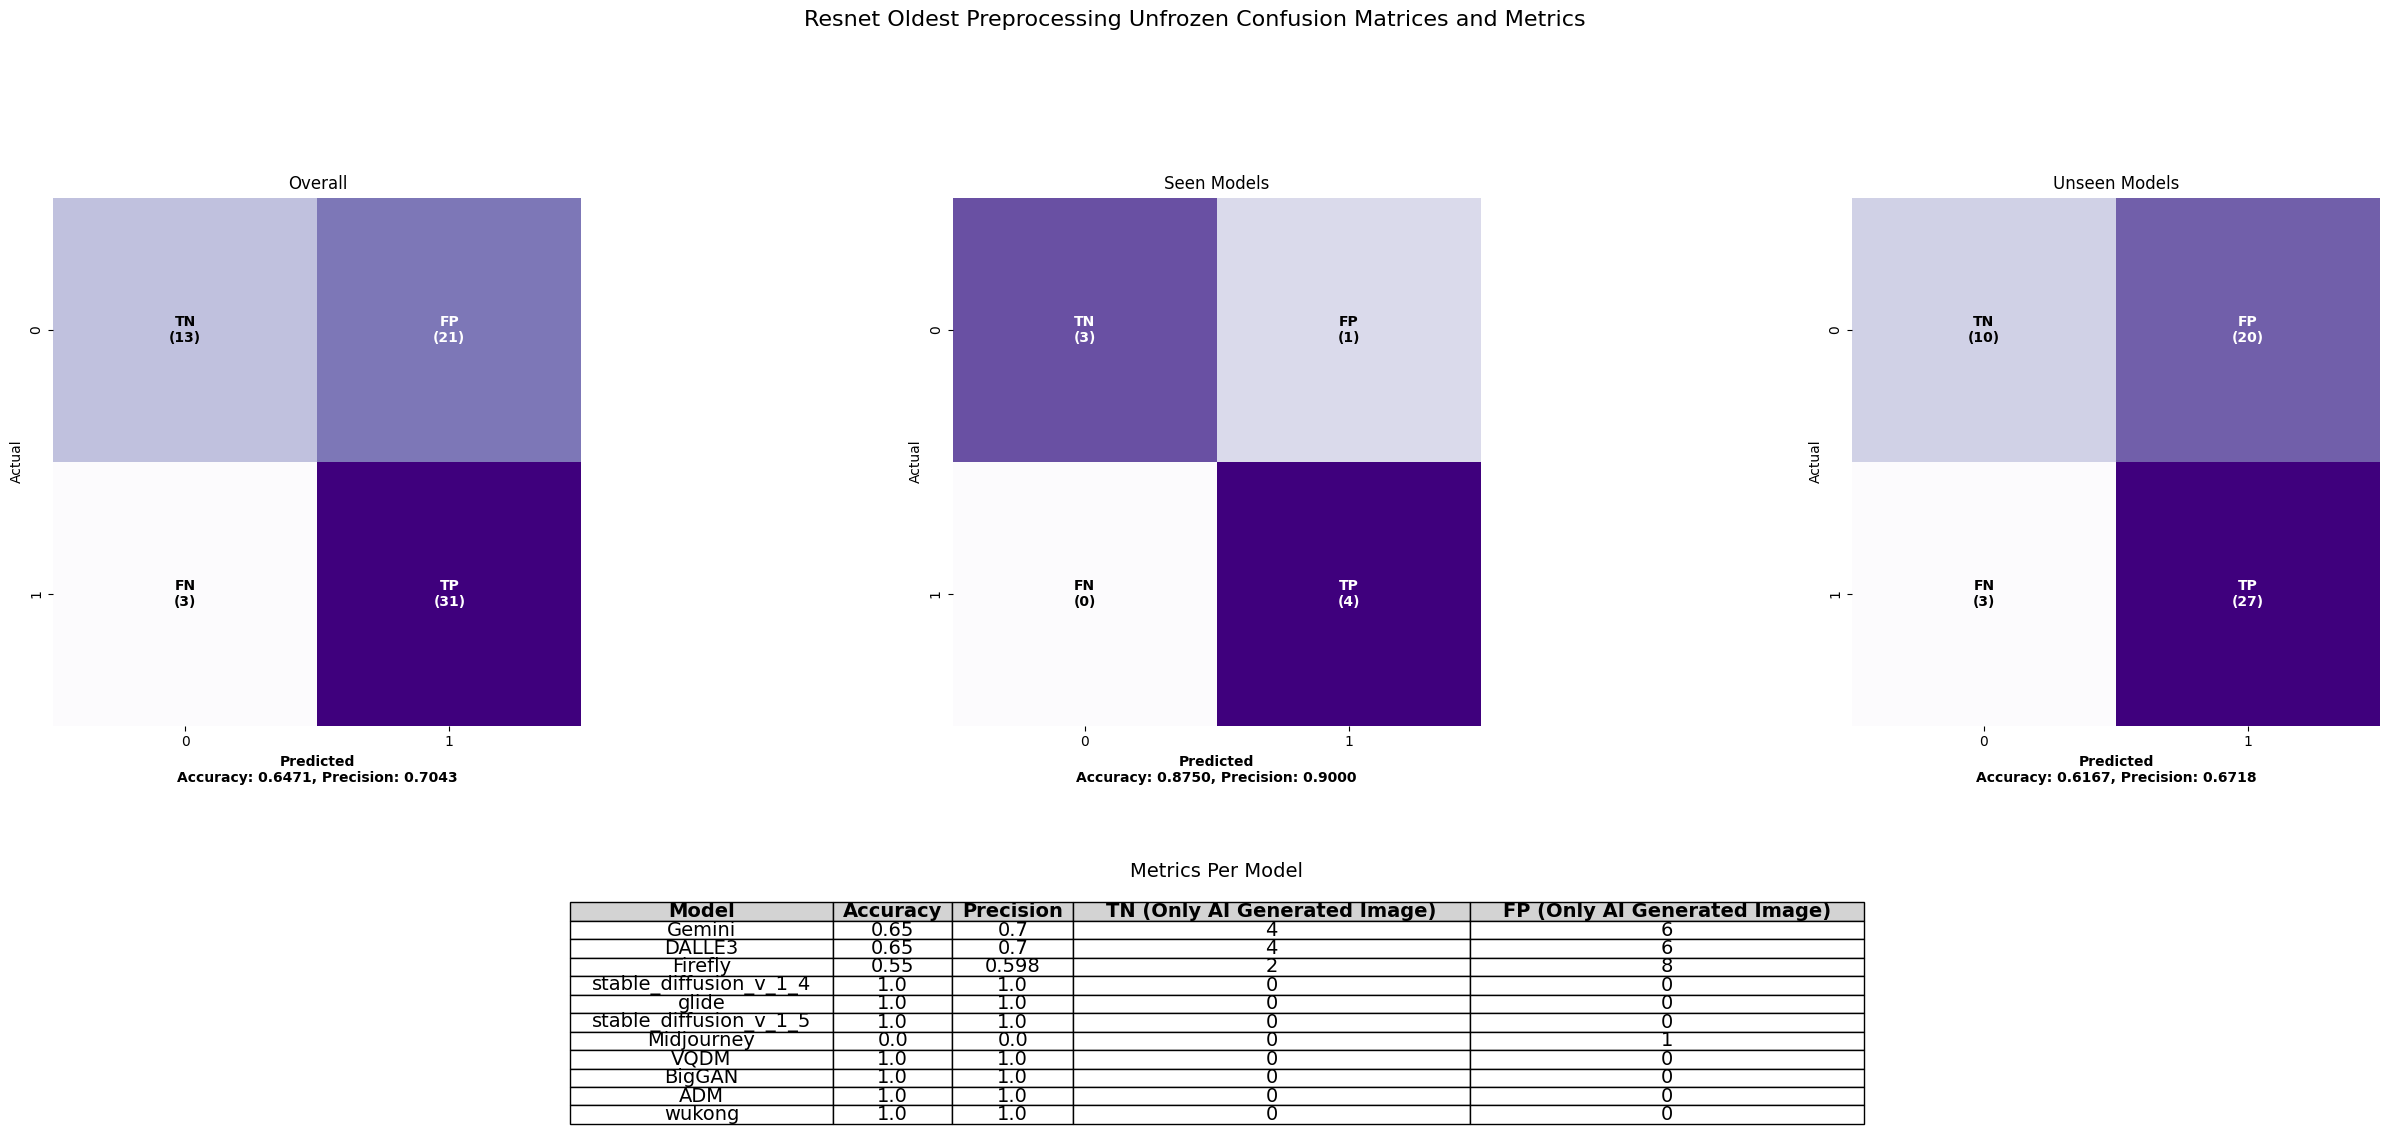

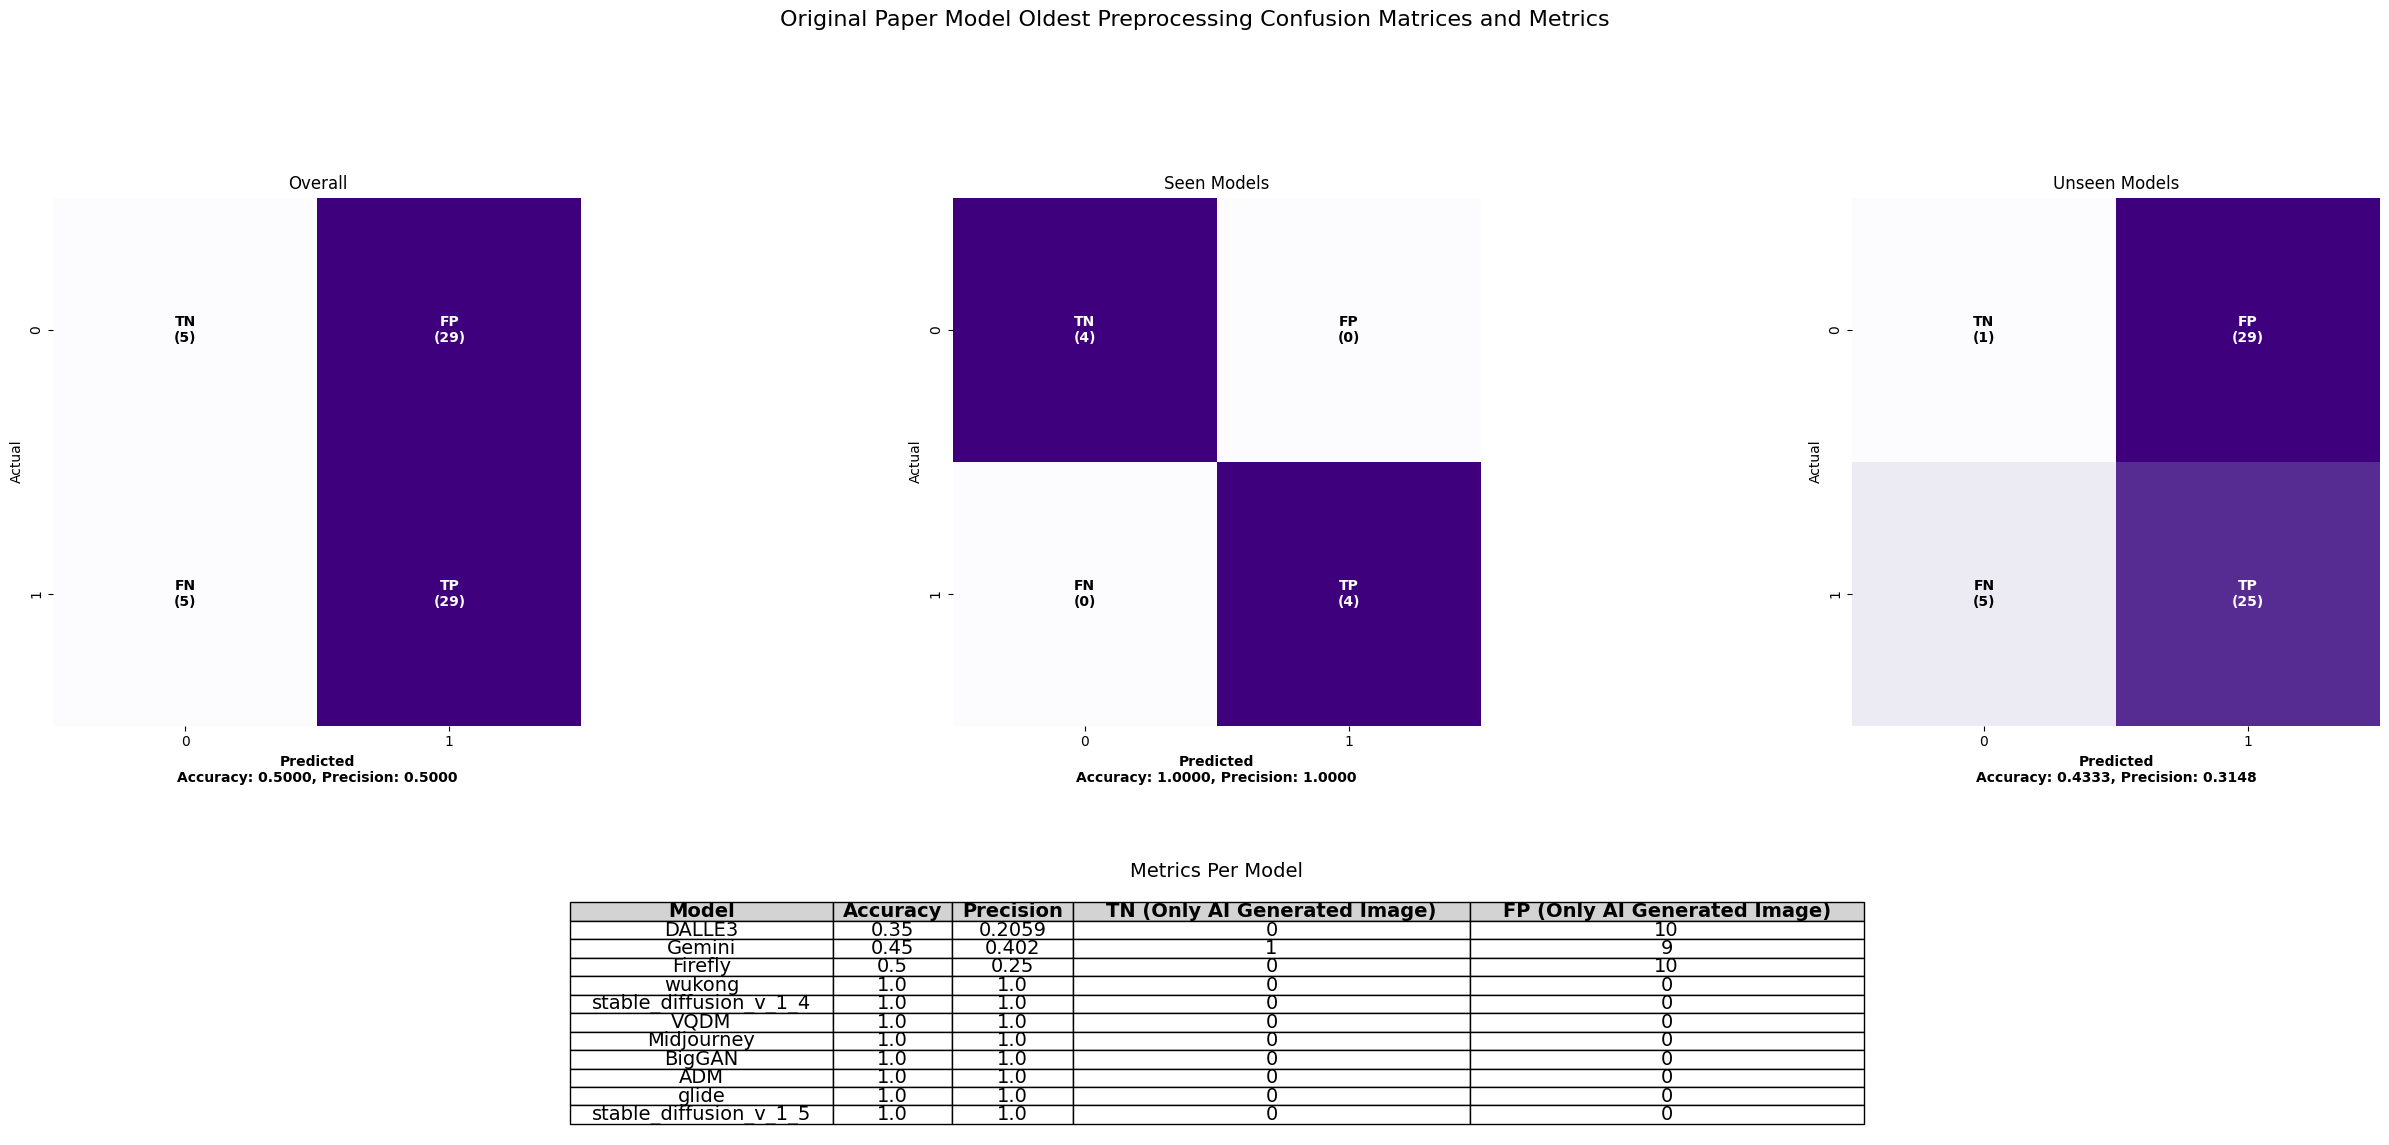

In [4]:
print("Old Preprocessing")

ut.test(model_SWIN_oldPre, test_loader_old_pre, 
        device,"/home/kosta/code/School/SentryAI/pth/best_model_OldestPre_SWIN_frozen.pth",
        "Swin Transformer v2 Oldest Preprocessing Frozen")
ut.test(model_SWIN_oldPre, test_loader_old_pre,
        device,"/home/kosta/code/School/SentryAI/pth/best_model_OldestPre_SWIN_Unfrozen.pth",
        "Swin Transformer v2 Oldest Preprocessing Unfrozen")
ut.test(model_RESNET_oldPre, test_loader_old_pre,
        device,"/home/kosta/code/School/SentryAI/pth/best_model_OldestPre_RESNET_frozen.pth",
        "Resnet Oldest Preprocessing Frozen")
ut.test(model_RESNET_oldPre, test_loader_old_pre,
        device,"/home/kosta/code/School/SentryAI/pth/best_model_OldestPre_RESNET_Unfrozen.pth",
        "Resnet Oldest Preprocessing Unfrozen")
ut.test(model_Original_oldPre, test_loader_old_pre,
        device,"/home/kosta/code/School/SentryAI/pth/best_model_OldestPre_Base.pth",
        "Original Paper Model Oldest Preprocessing")



Old Smash and Reconstruct w/MultiFilterCNN


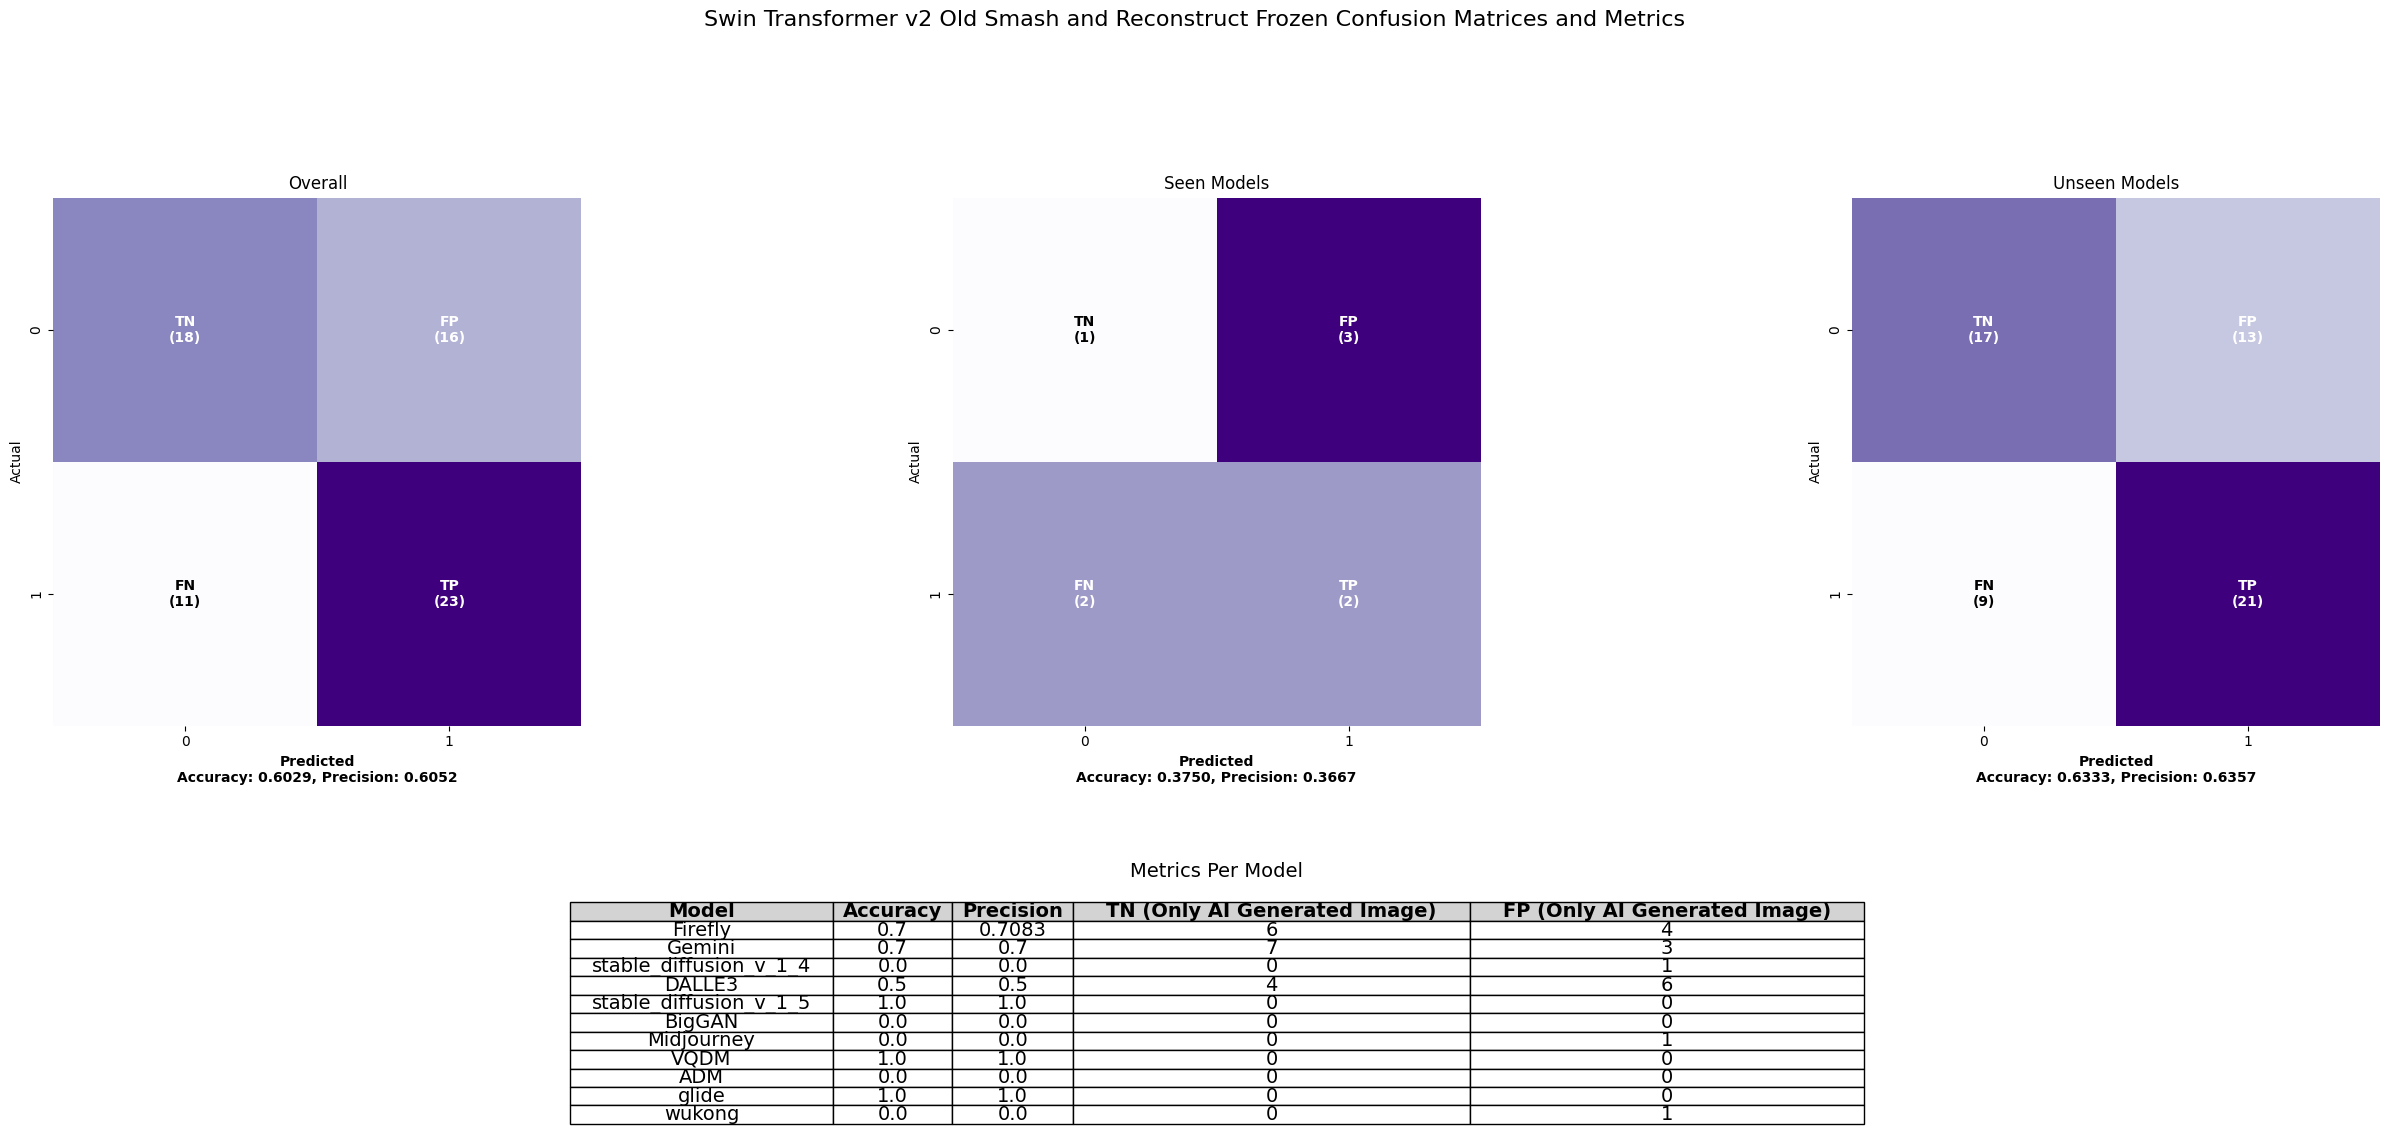

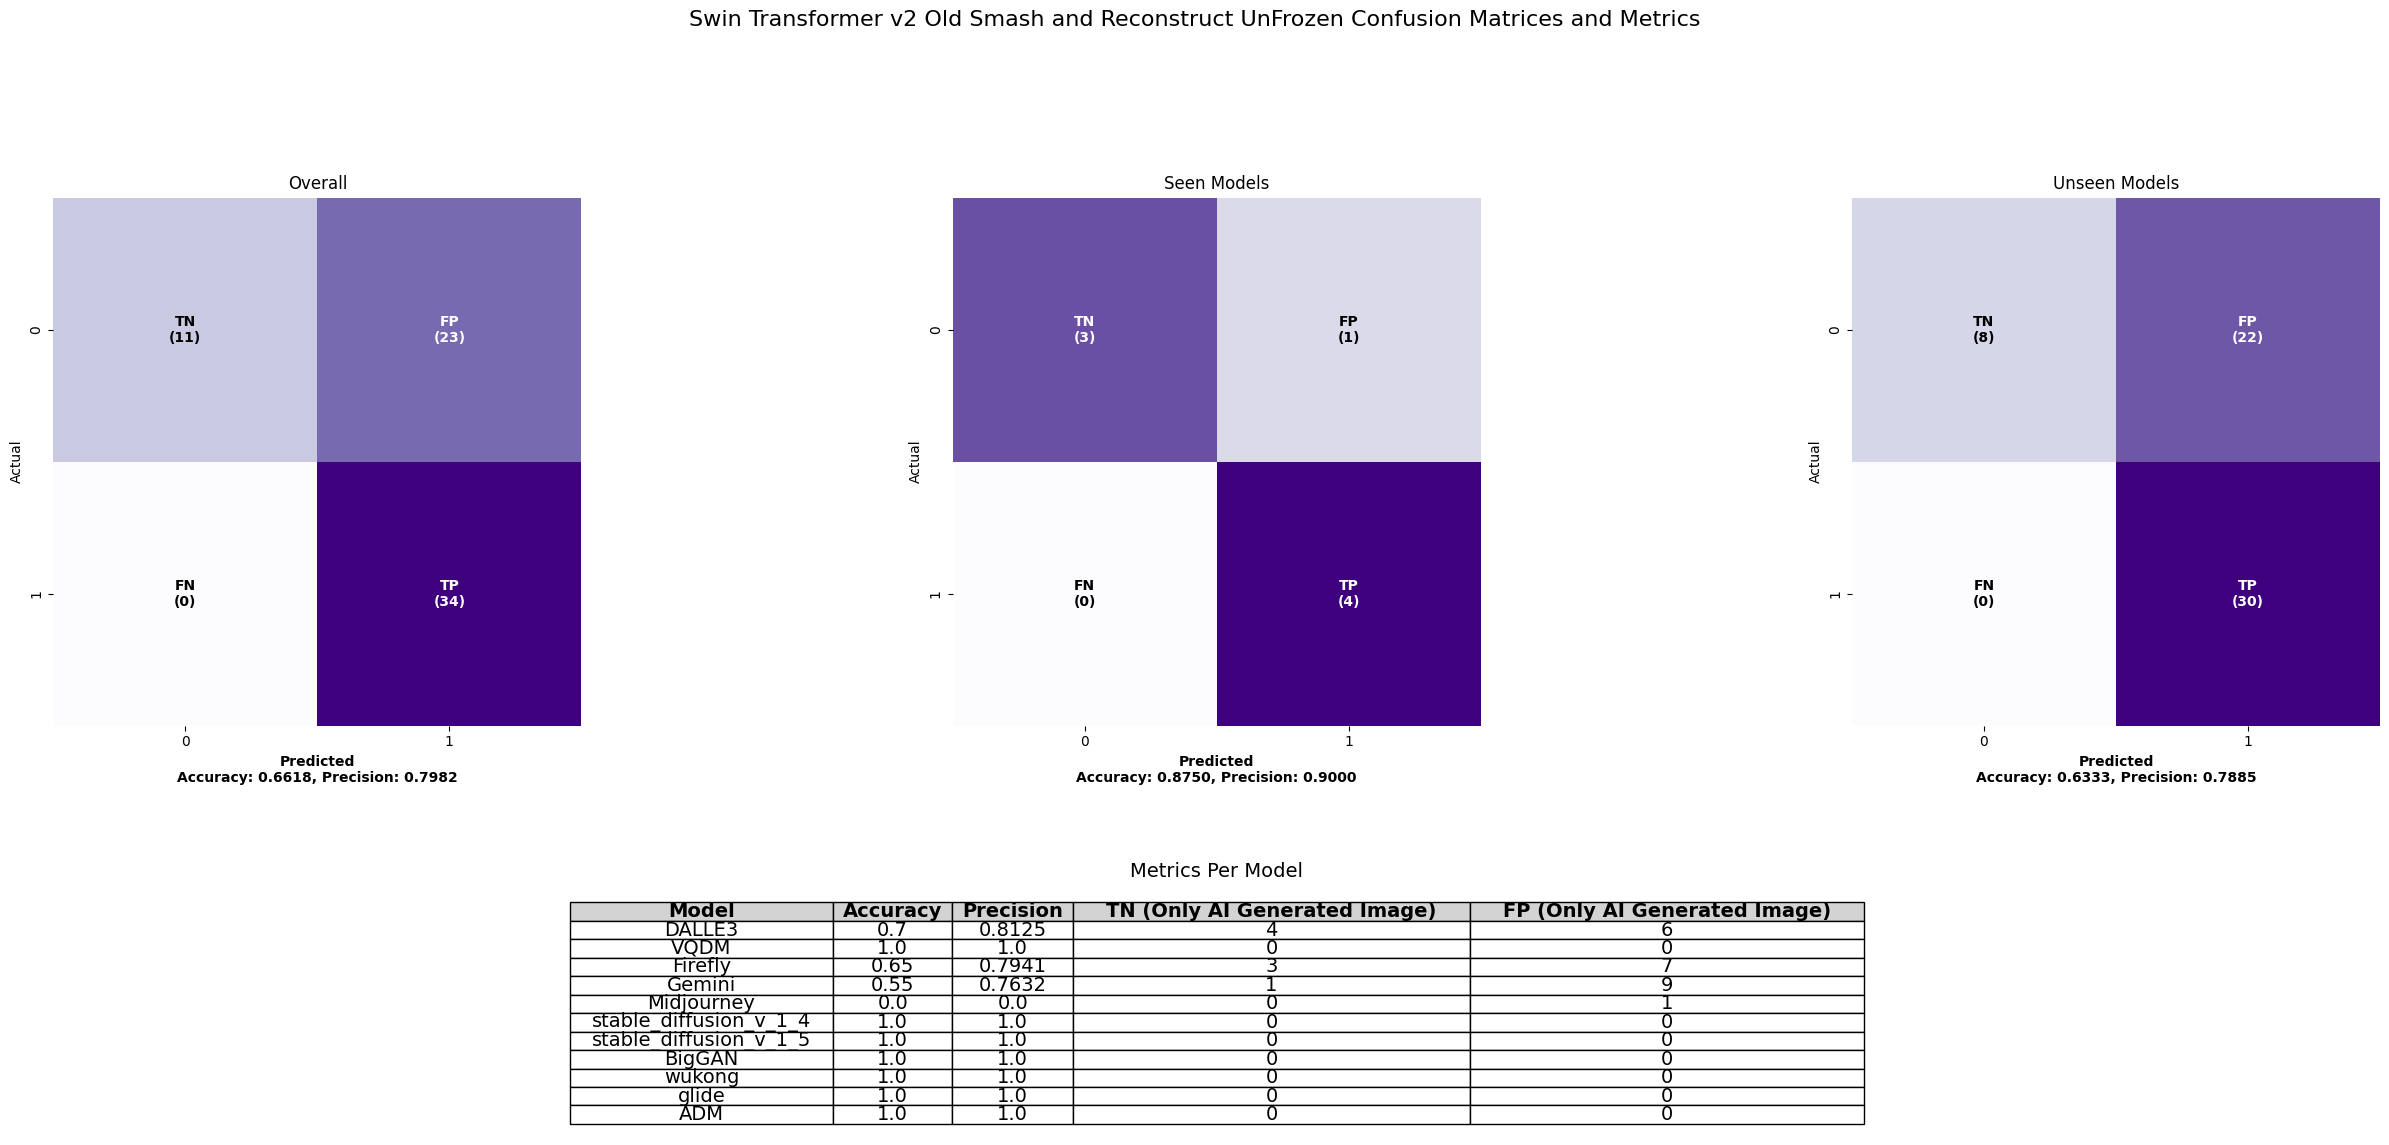

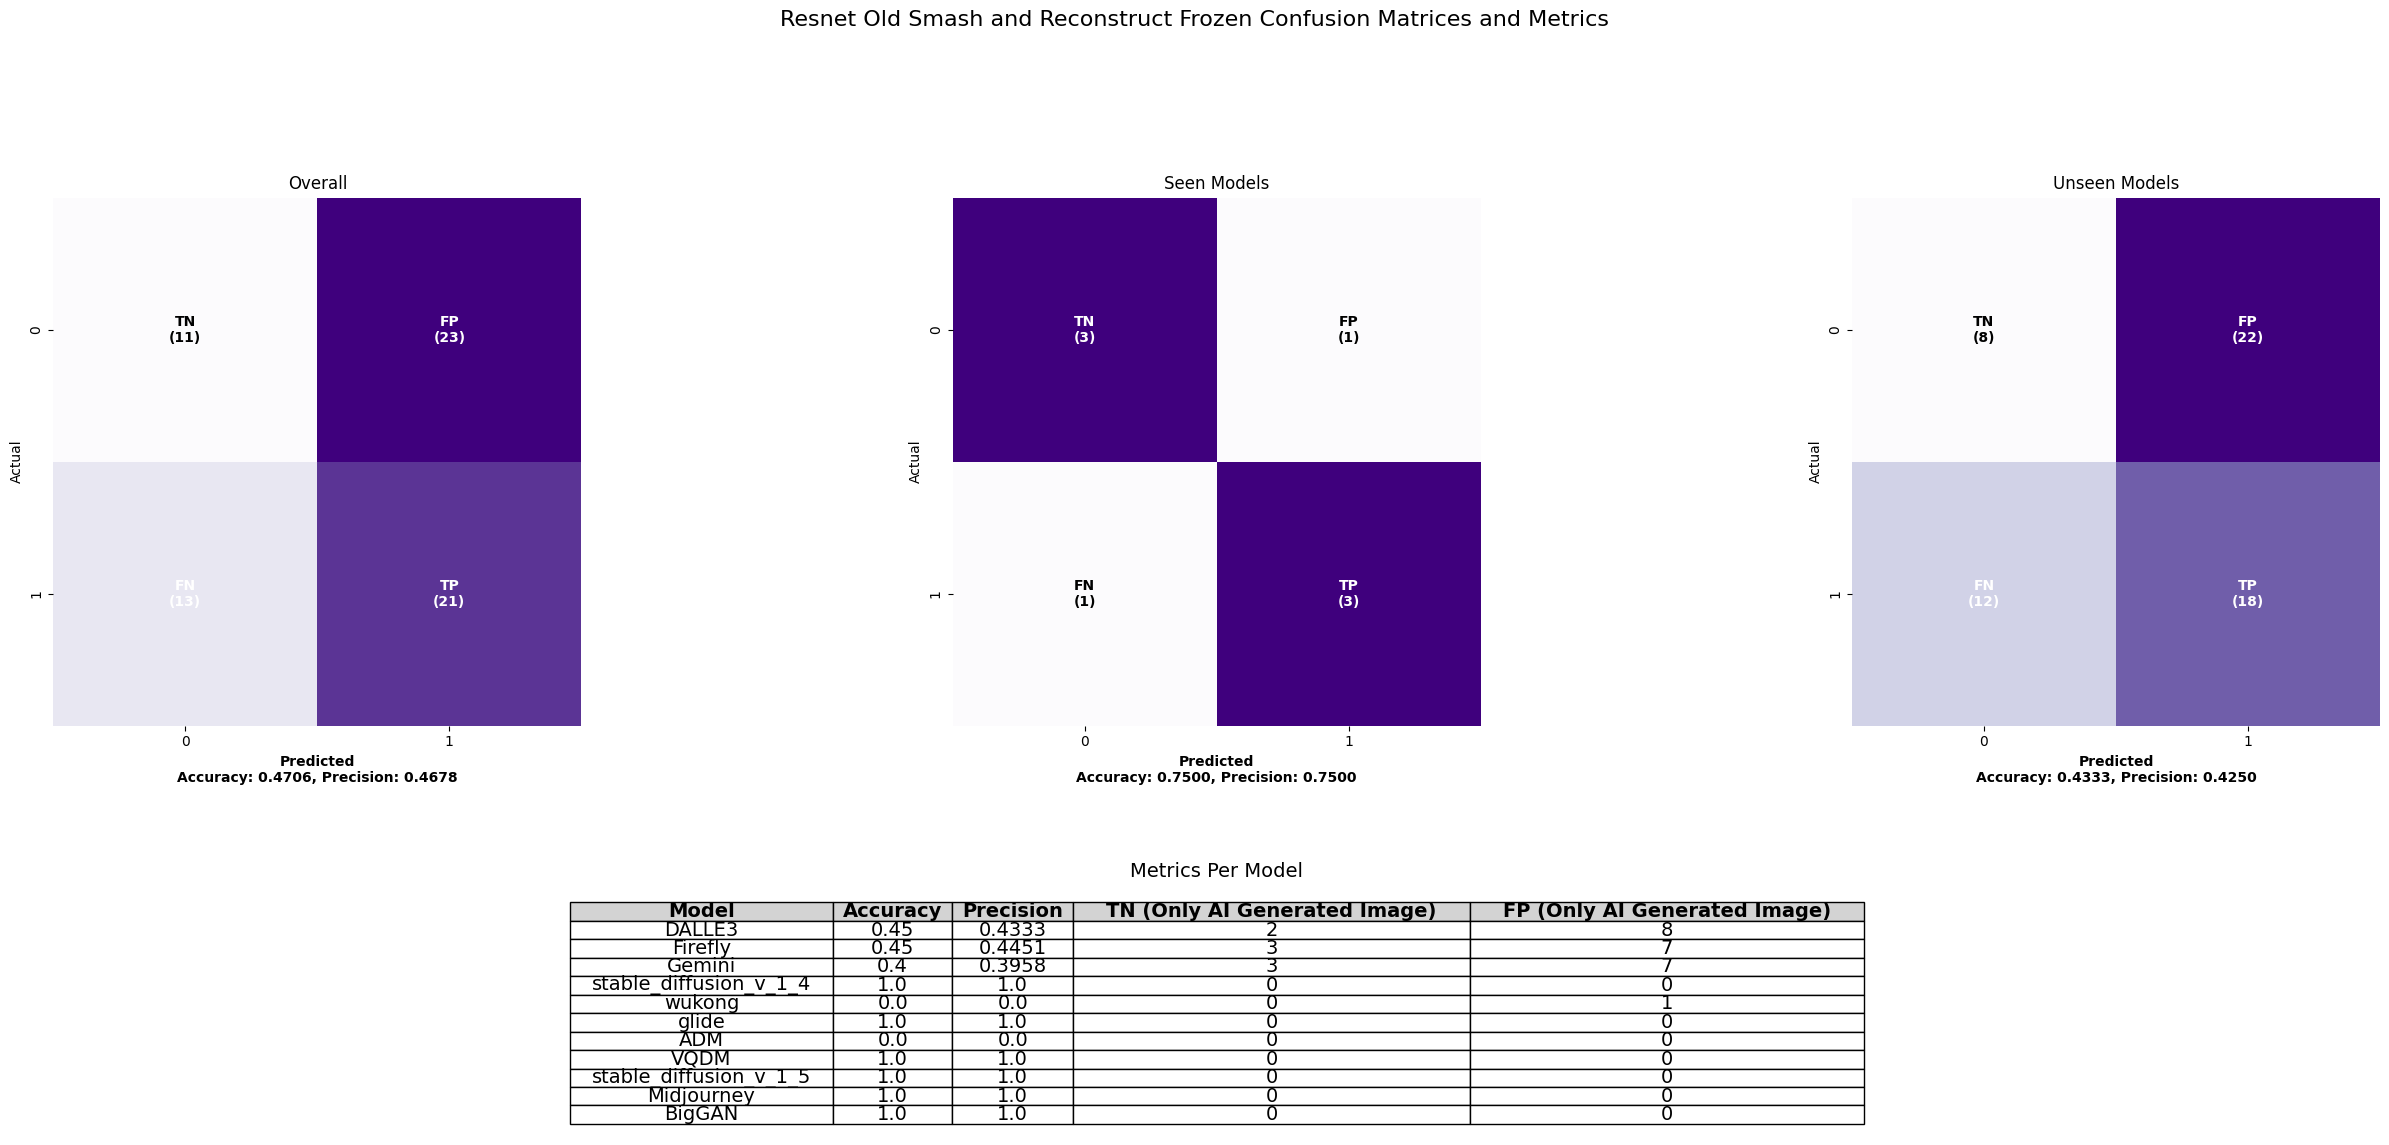

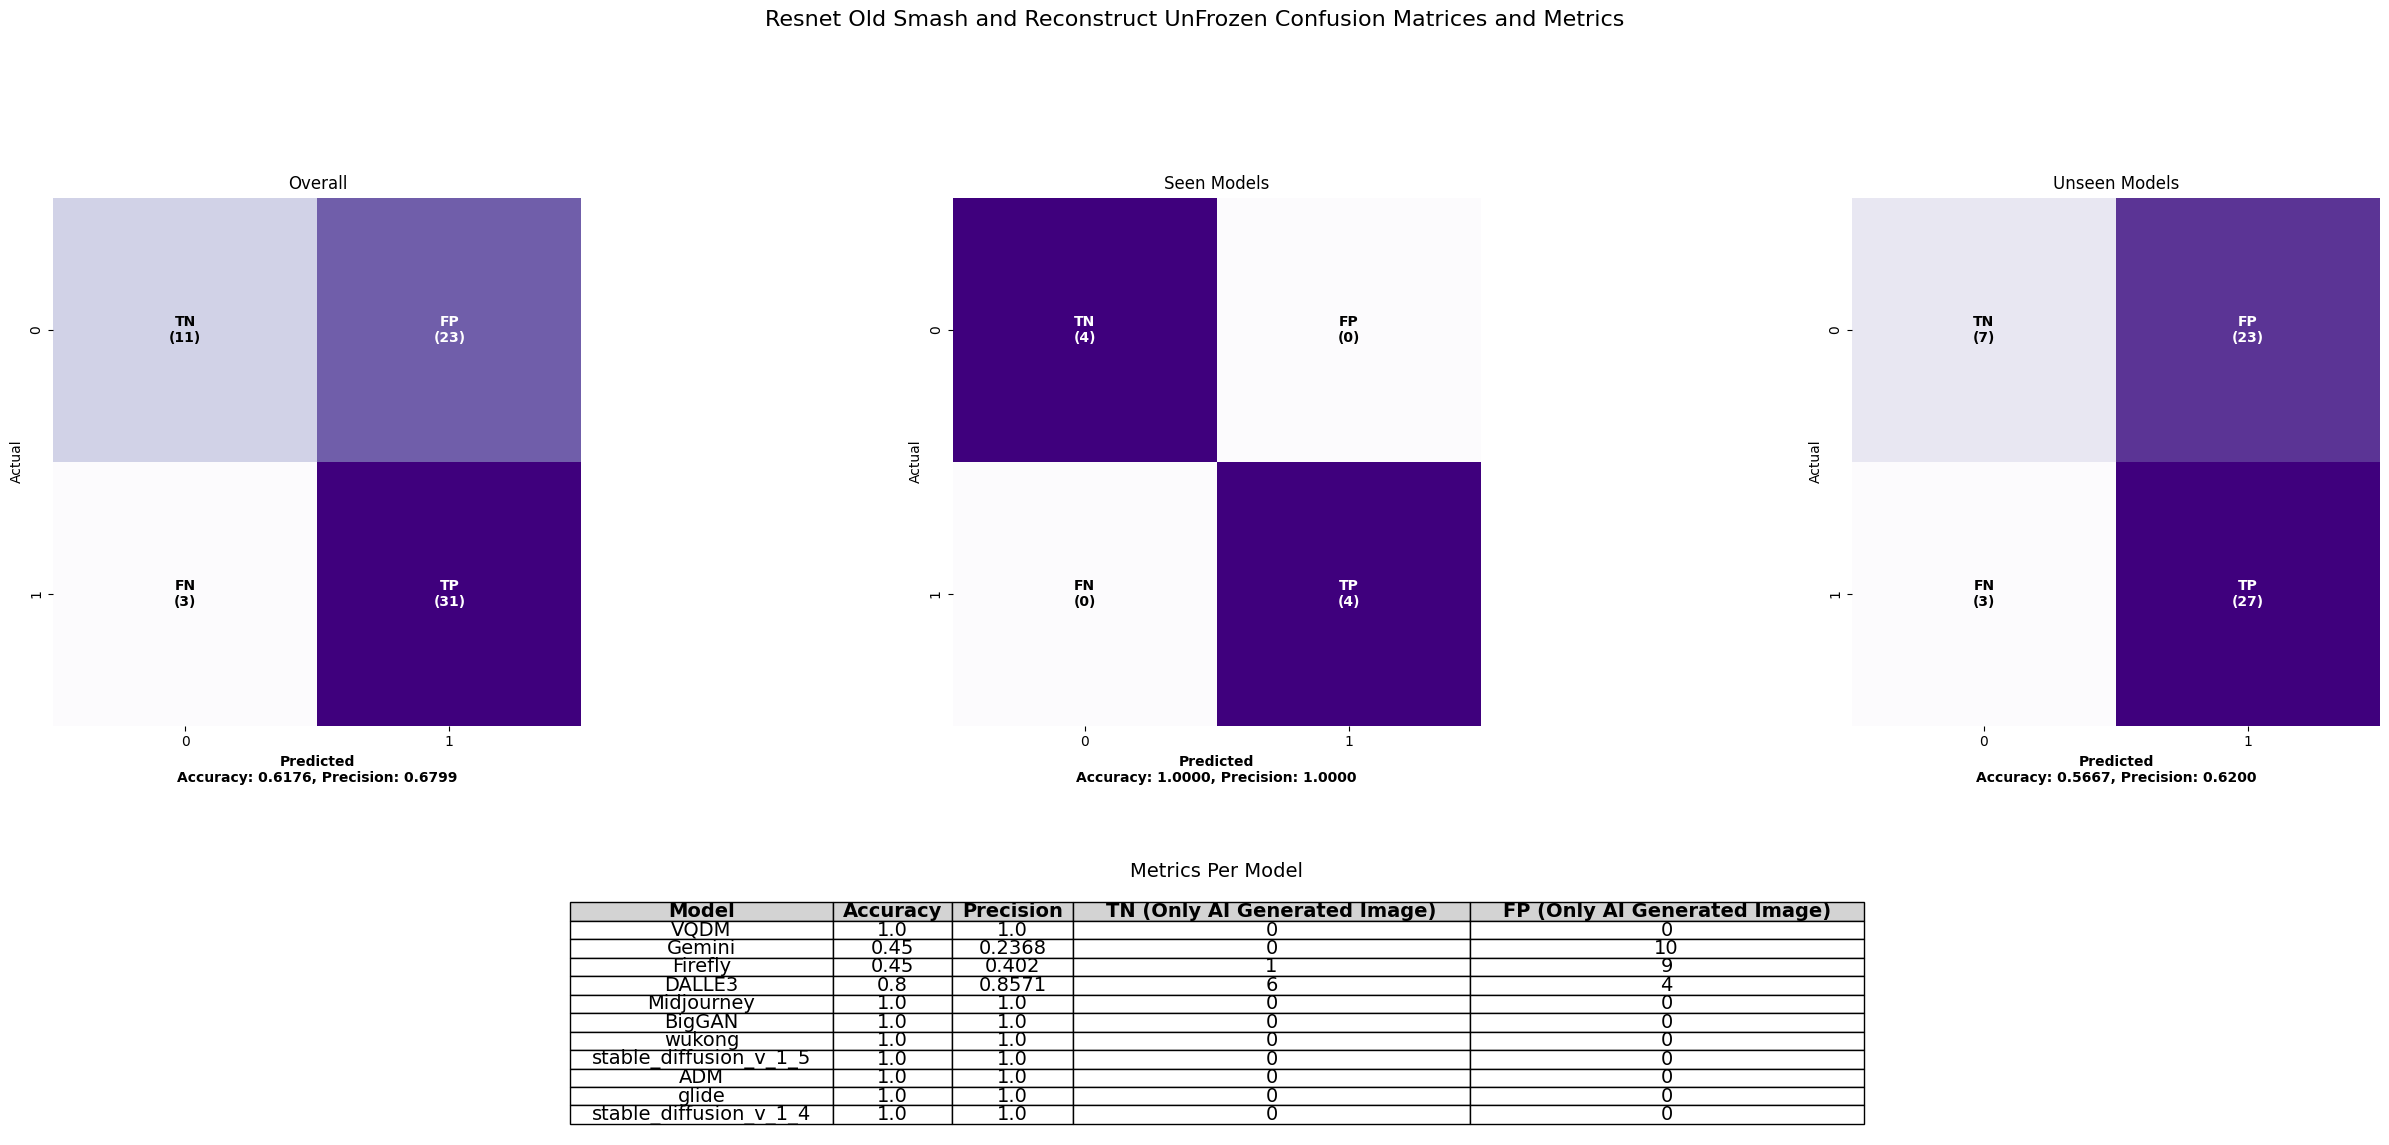

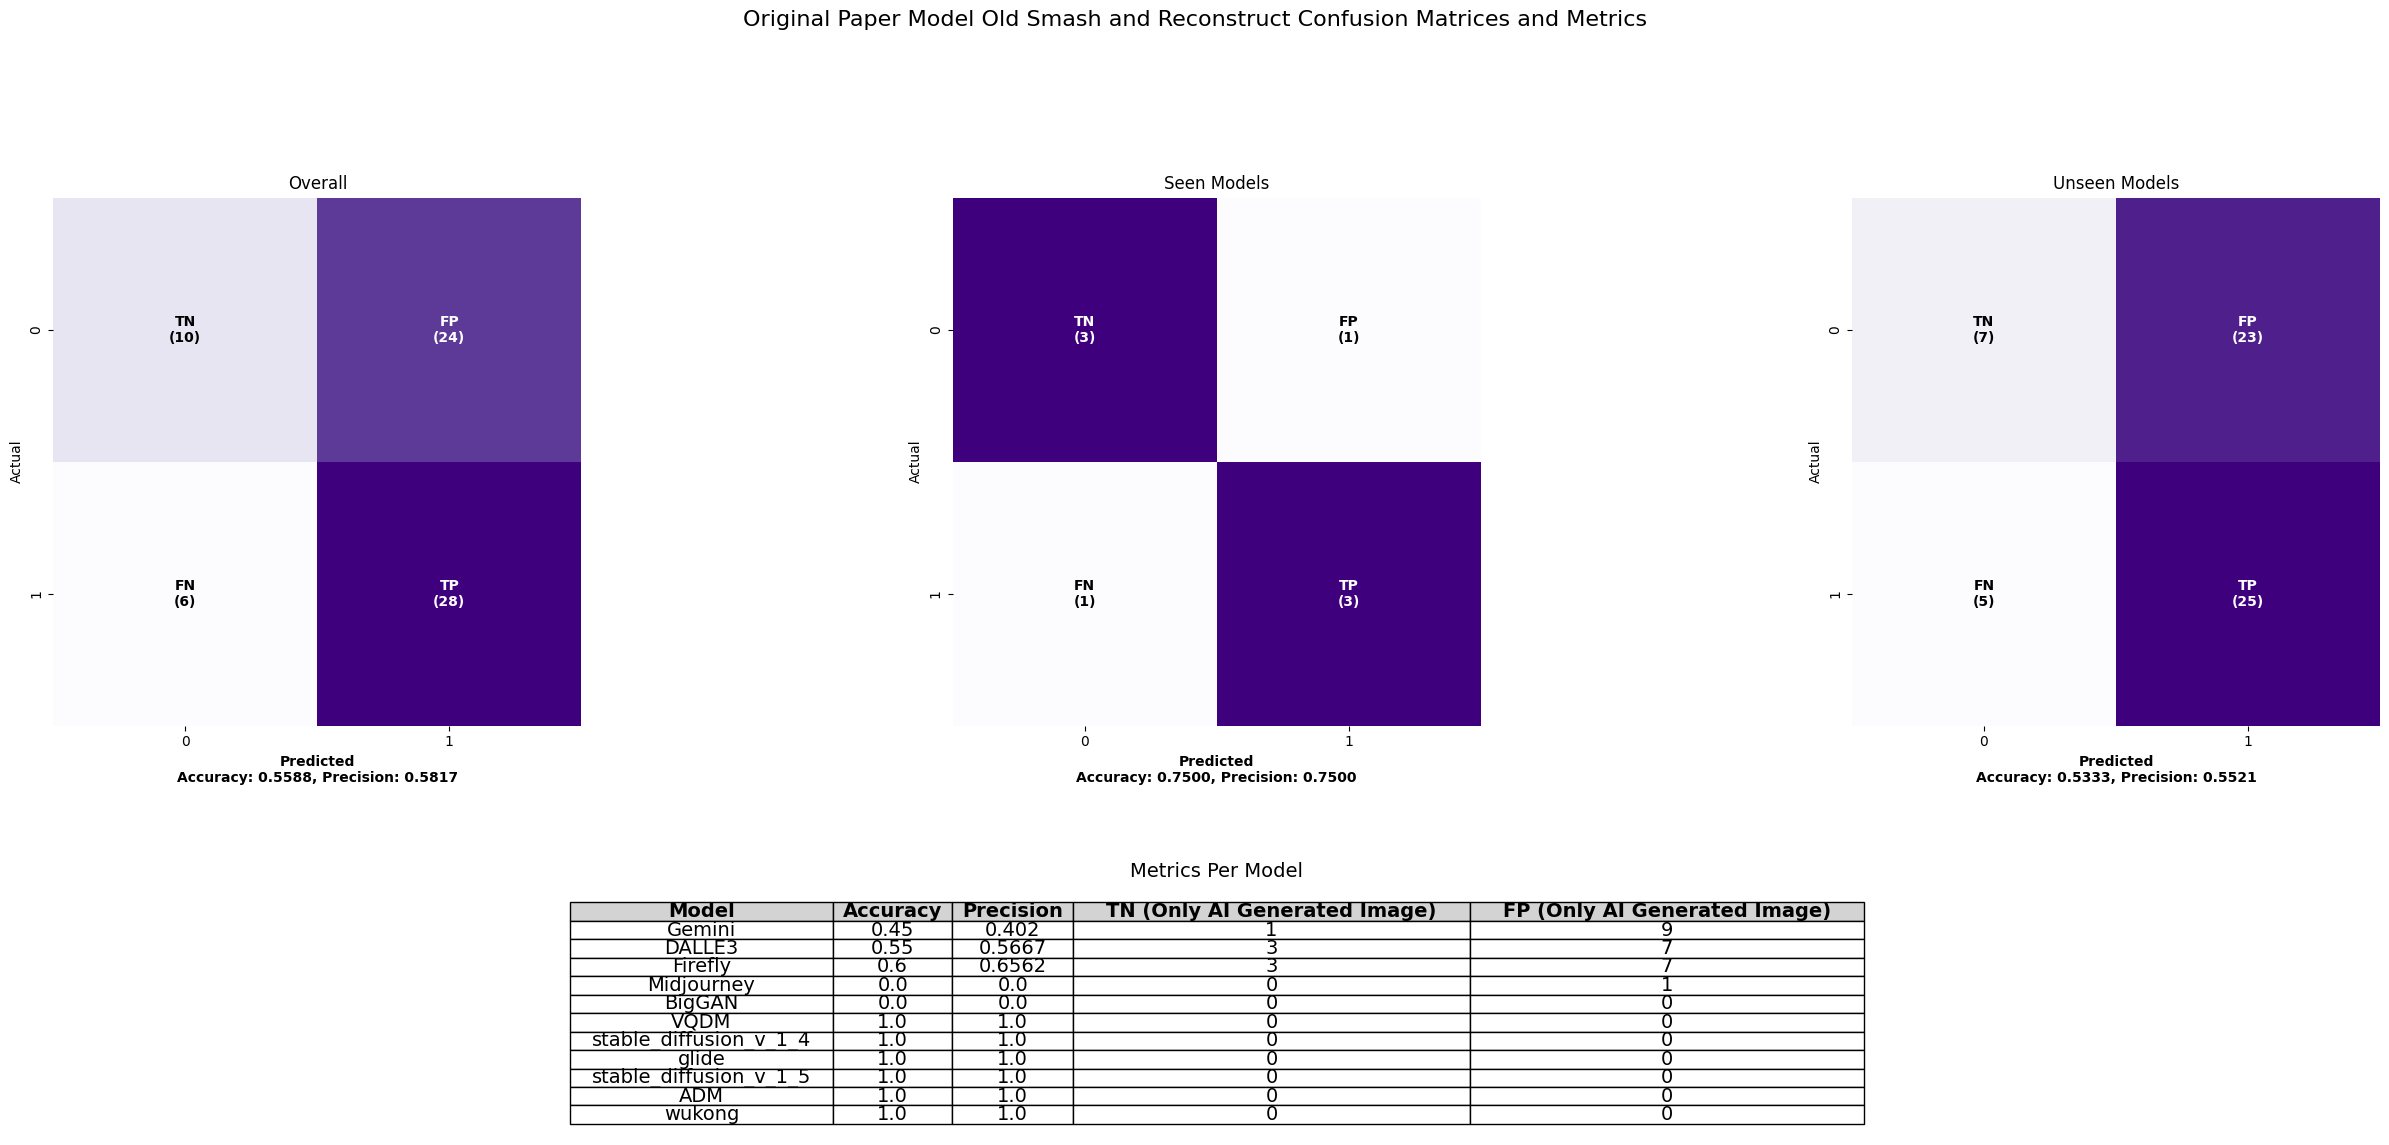

In [5]:
print("Old Smash and Reconstruct w/MultiFilterCNN")

ut.test(model_SWIN_MultiImage, test_loader_old_smr,
        device,"/home/kosta/code/School/SentryAI/pth/best_model_oldSMR_SWIN_frozen.pth",
        "Swin Transformer v2 Old Smash and Reconstruct Frozen")

ut.test(model_SWIN_MultiImage, test_loader_old_smr,
        device,"/home/kosta/code/School/SentryAI/pth/best_model_oldSMR_SWIN_Unfrozen.pth",
        "Swin Transformer v2 Old Smash and Reconstruct UnFrozen")

ut.test(model_RESNET_MultiImage, test_loader_old_smr,
        device,"/home/kosta/code/School/SentryAI/pth/best_model_oldSMR_RESNET_frozen.pth",
        "Resnet Old Smash and Reconstruct Frozen")

ut.test(model_RESNET_MultiImage, test_loader_old_smr,
        device,"/home/kosta/code/School/SentryAI/pth/best_model_oldSMR_RESNET_unfrozen.pth",
        "Resnet Old Smash and Reconstruct UnFrozen")

ut.test(model_Original_MultiImage, test_loader_old_smr,
        device,"/home/kosta/code/School/SentryAI/pth/best_model_oldSMR_Base.pth",
        "Original Paper Model Old Smash and Reconstruct")


New Preprocessing


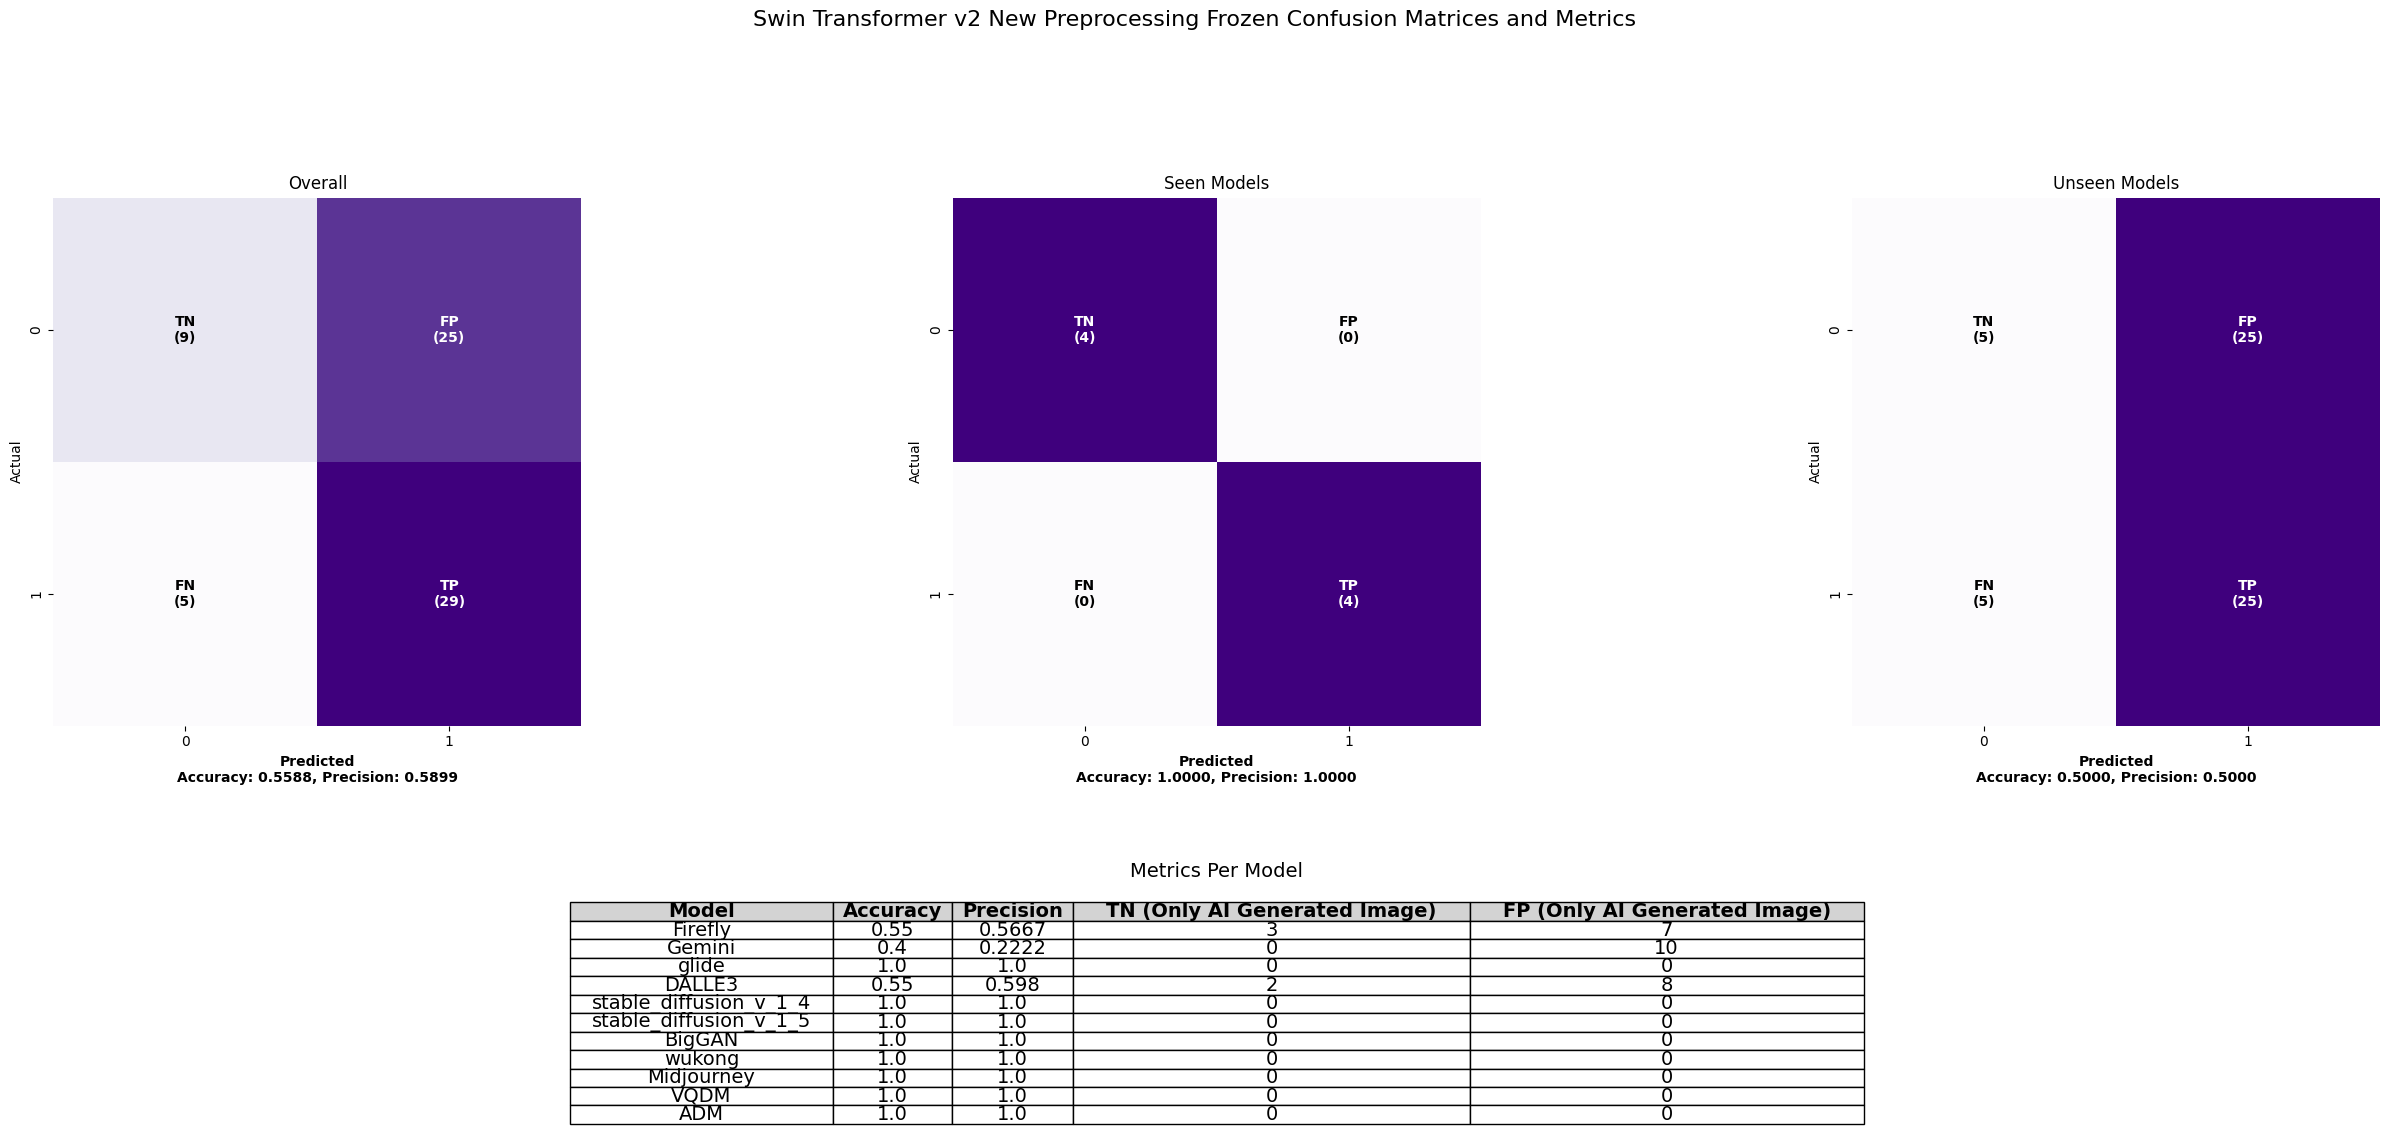

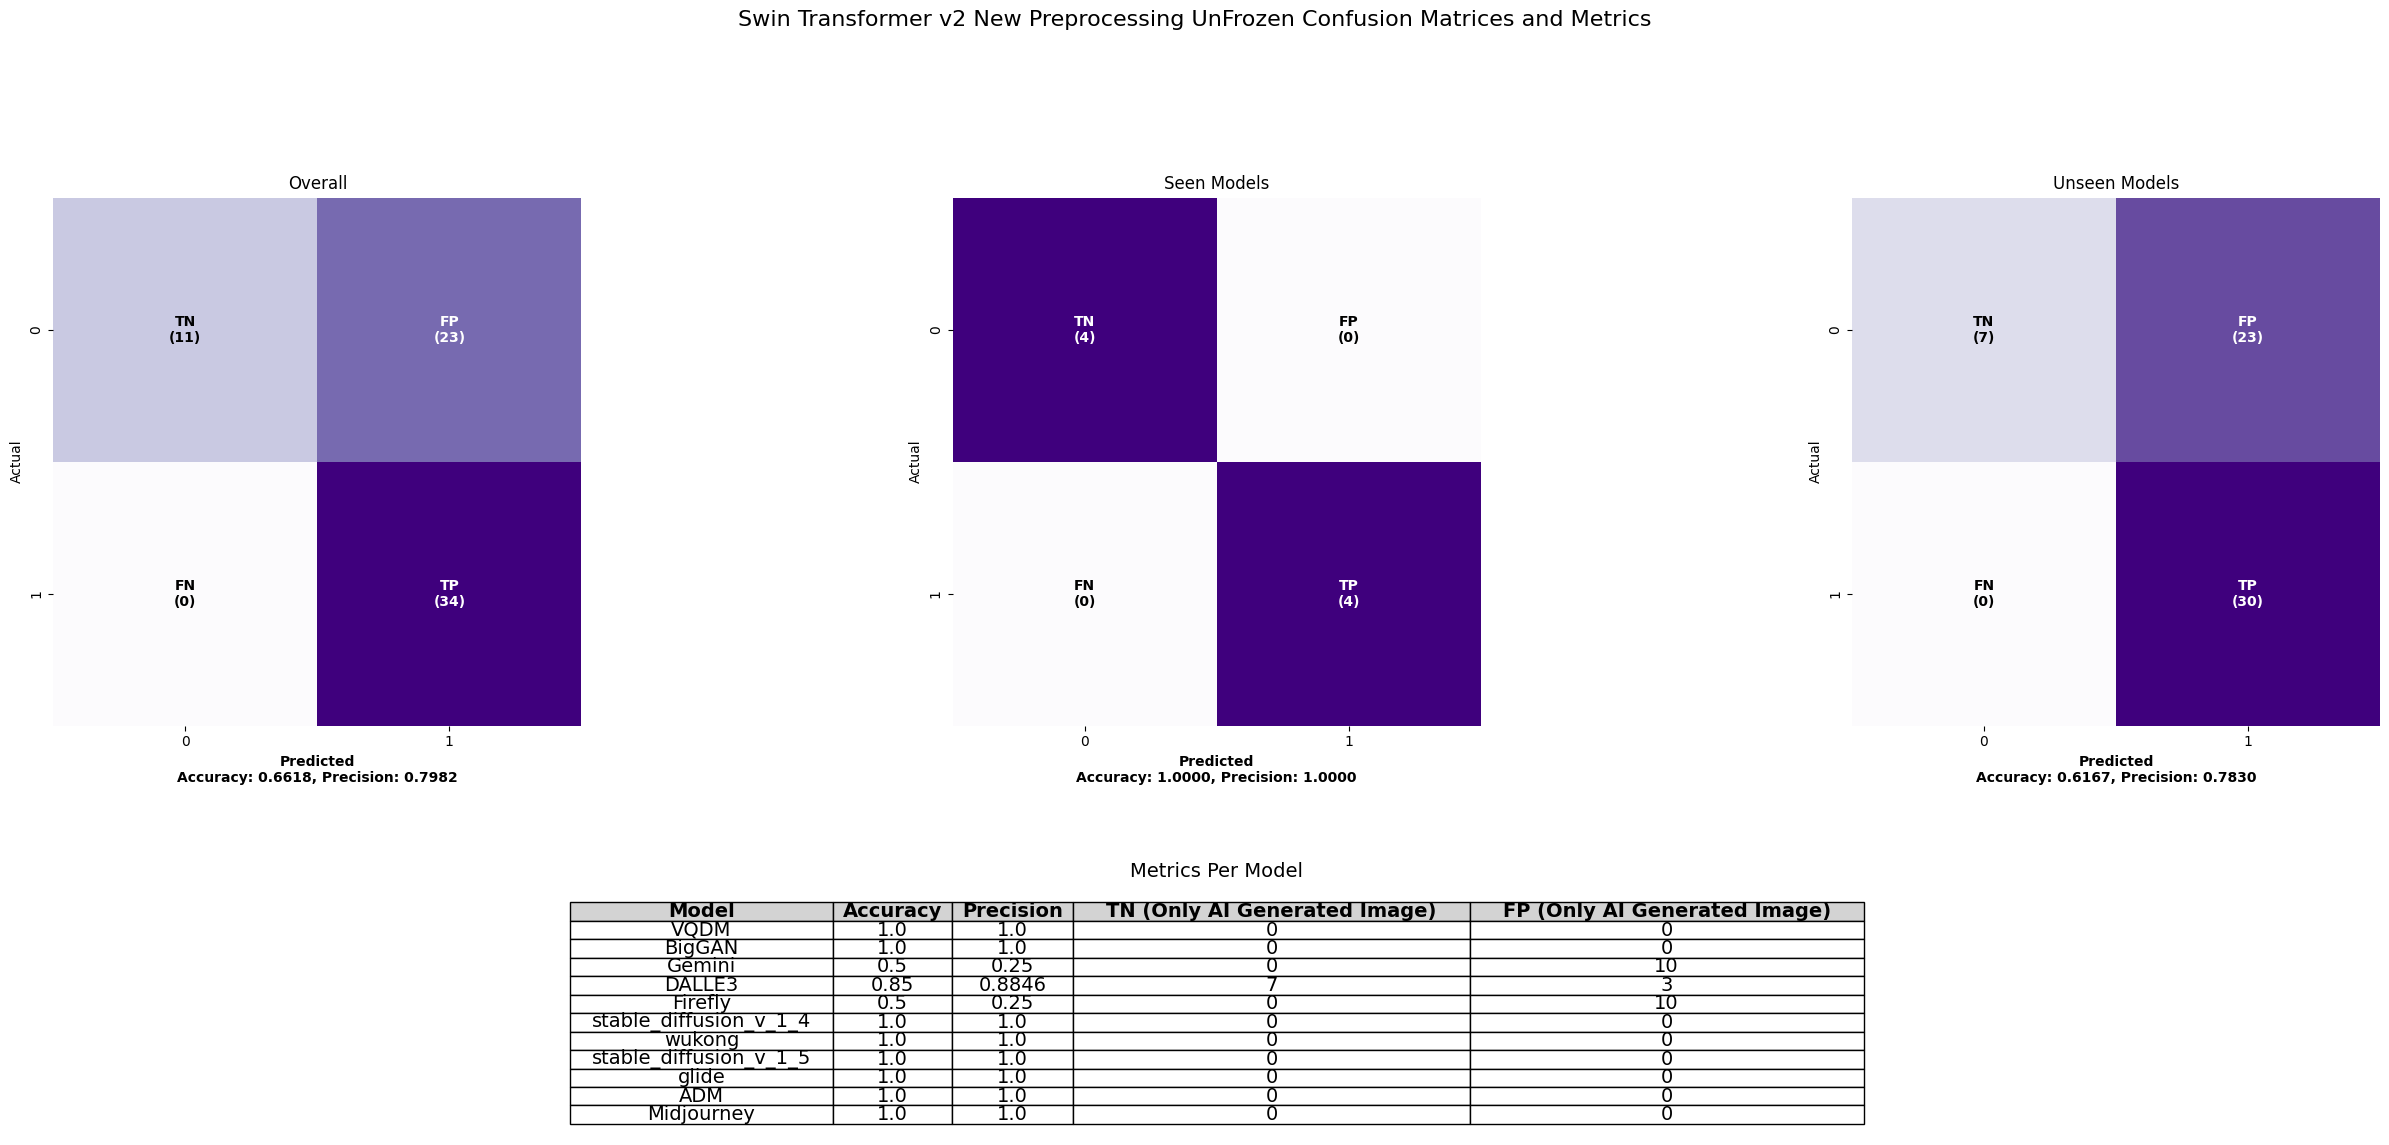

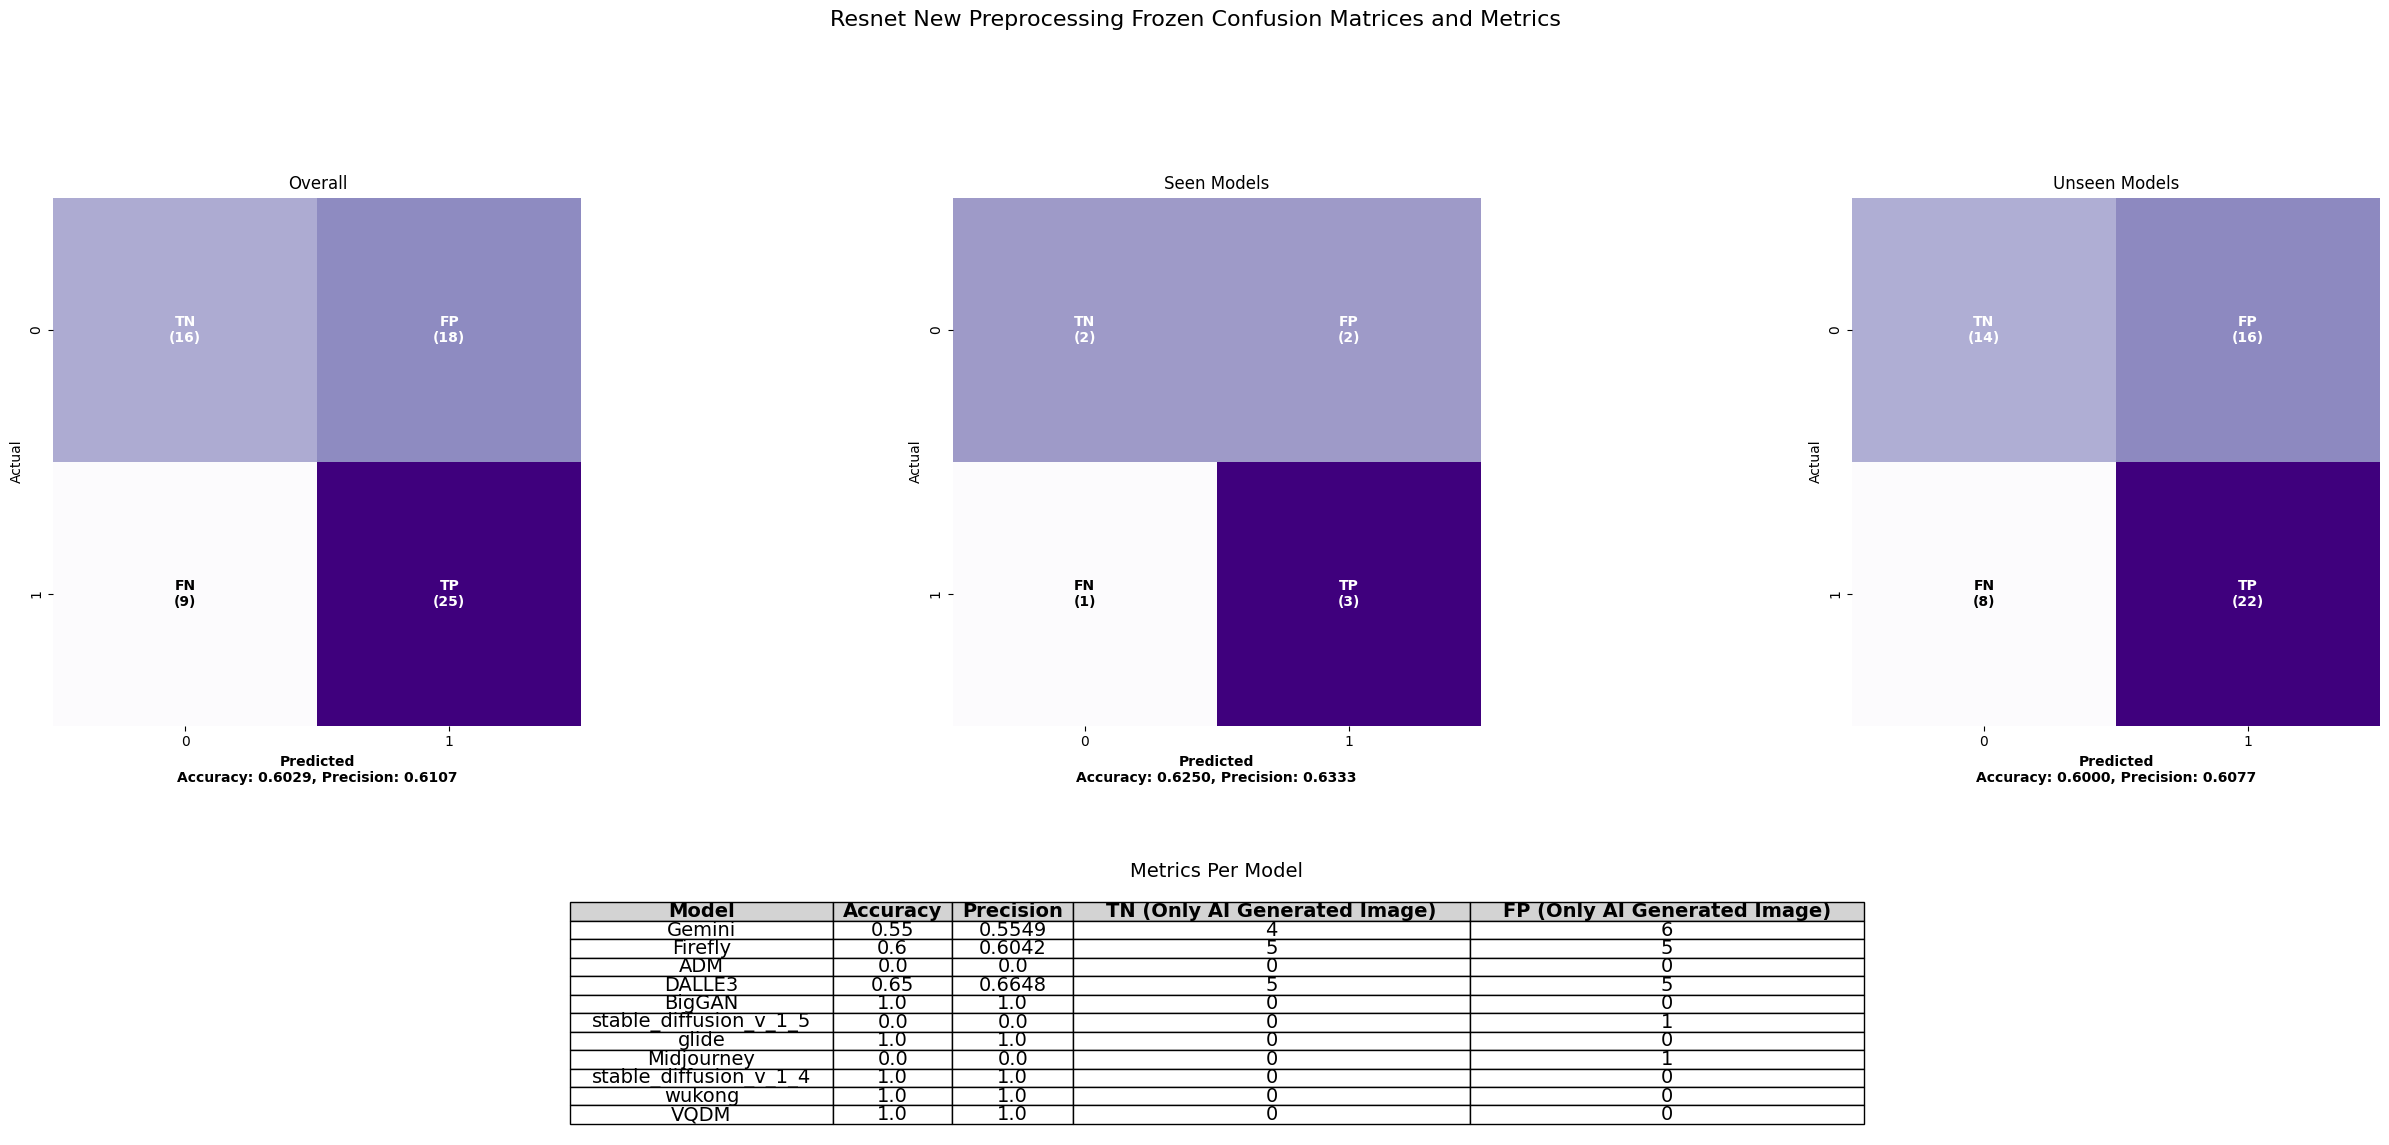

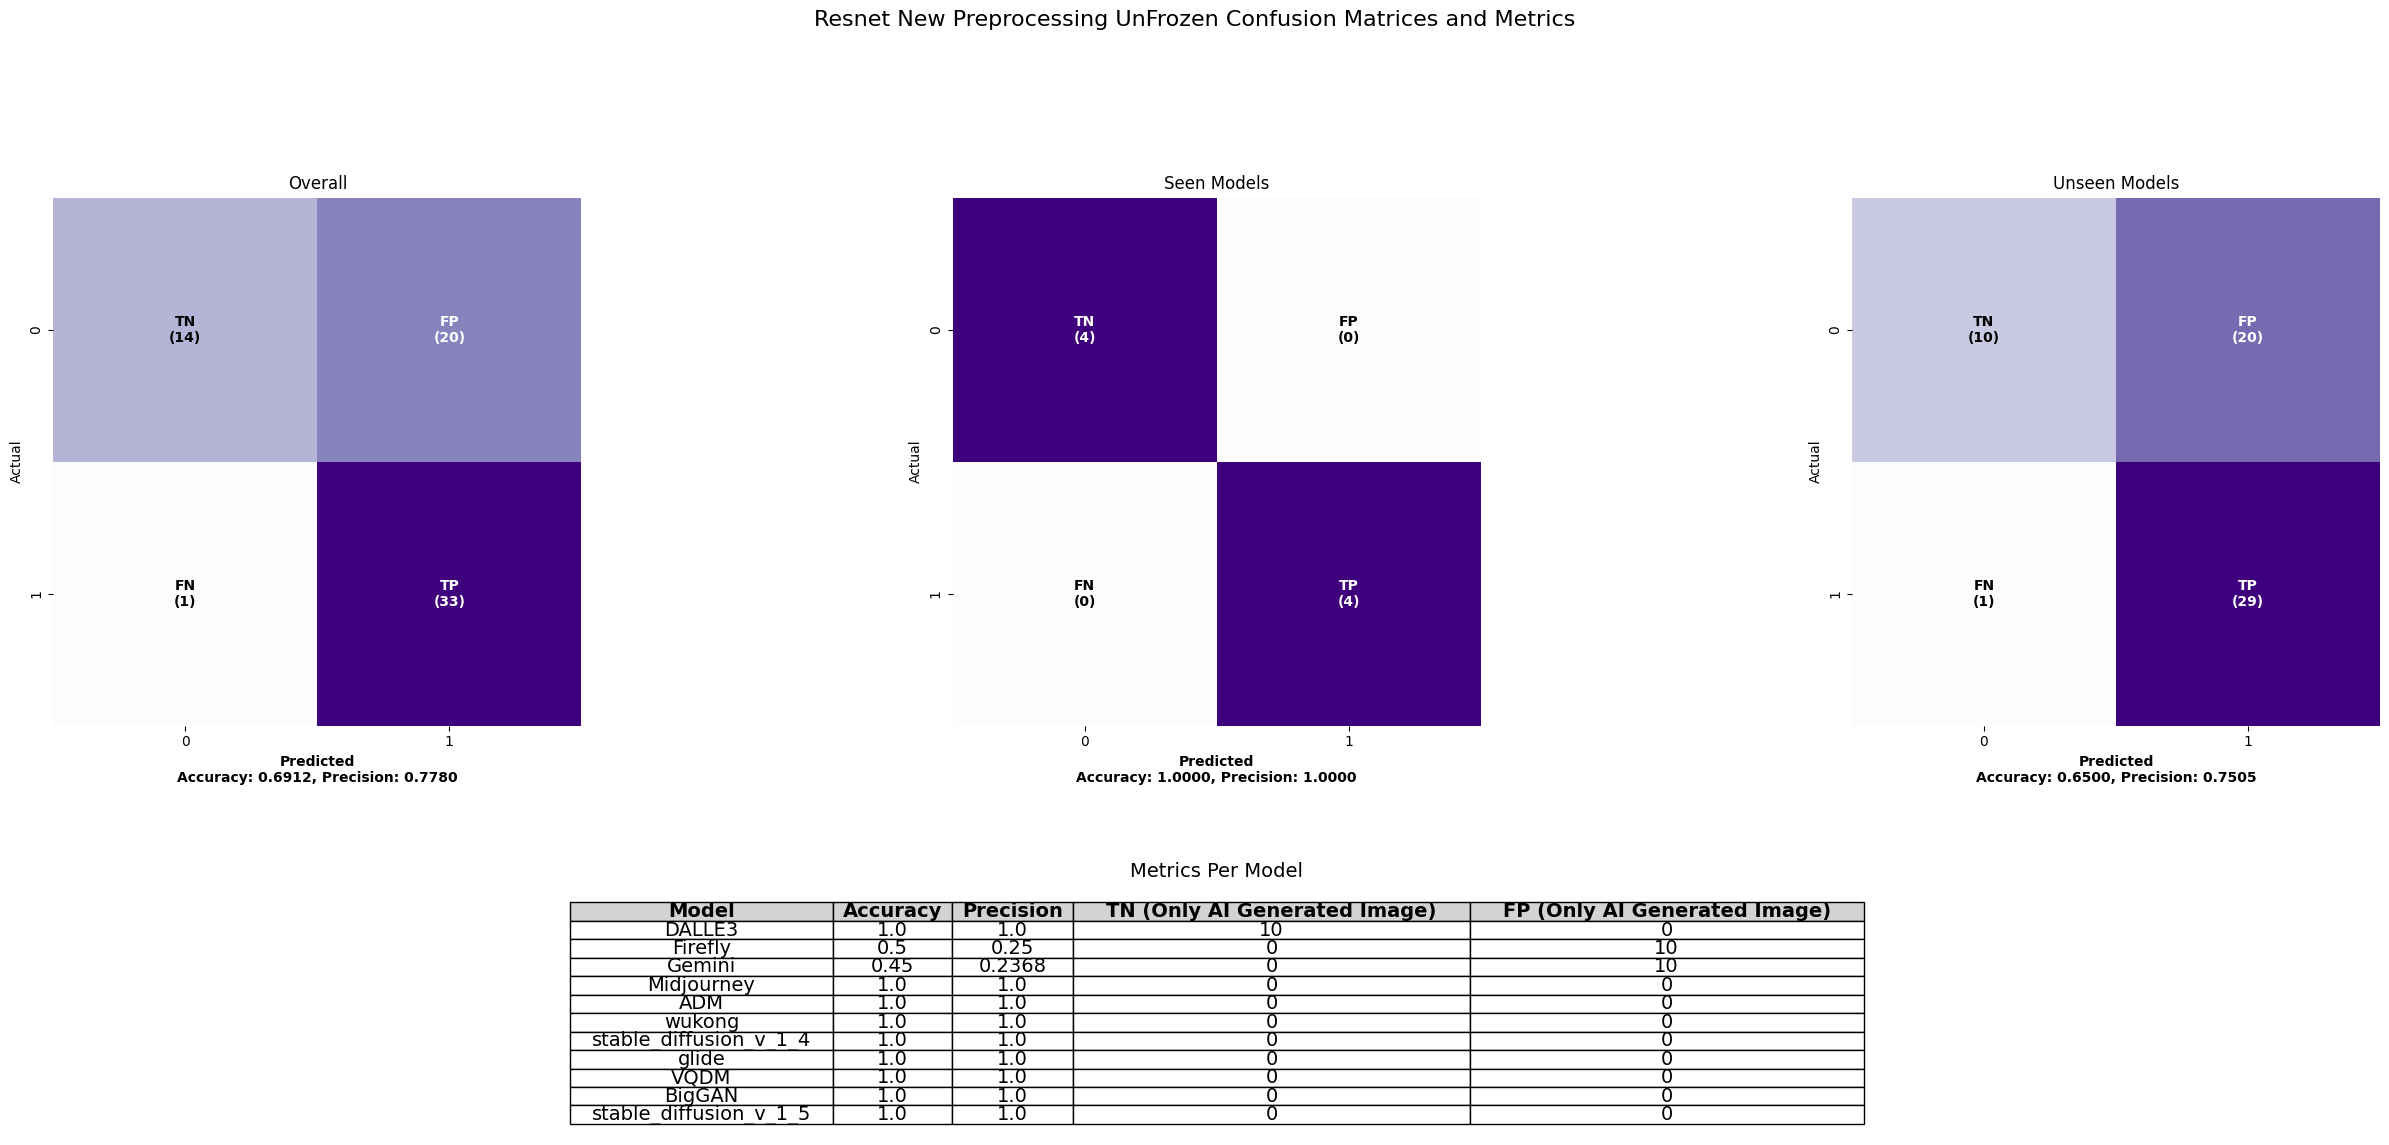

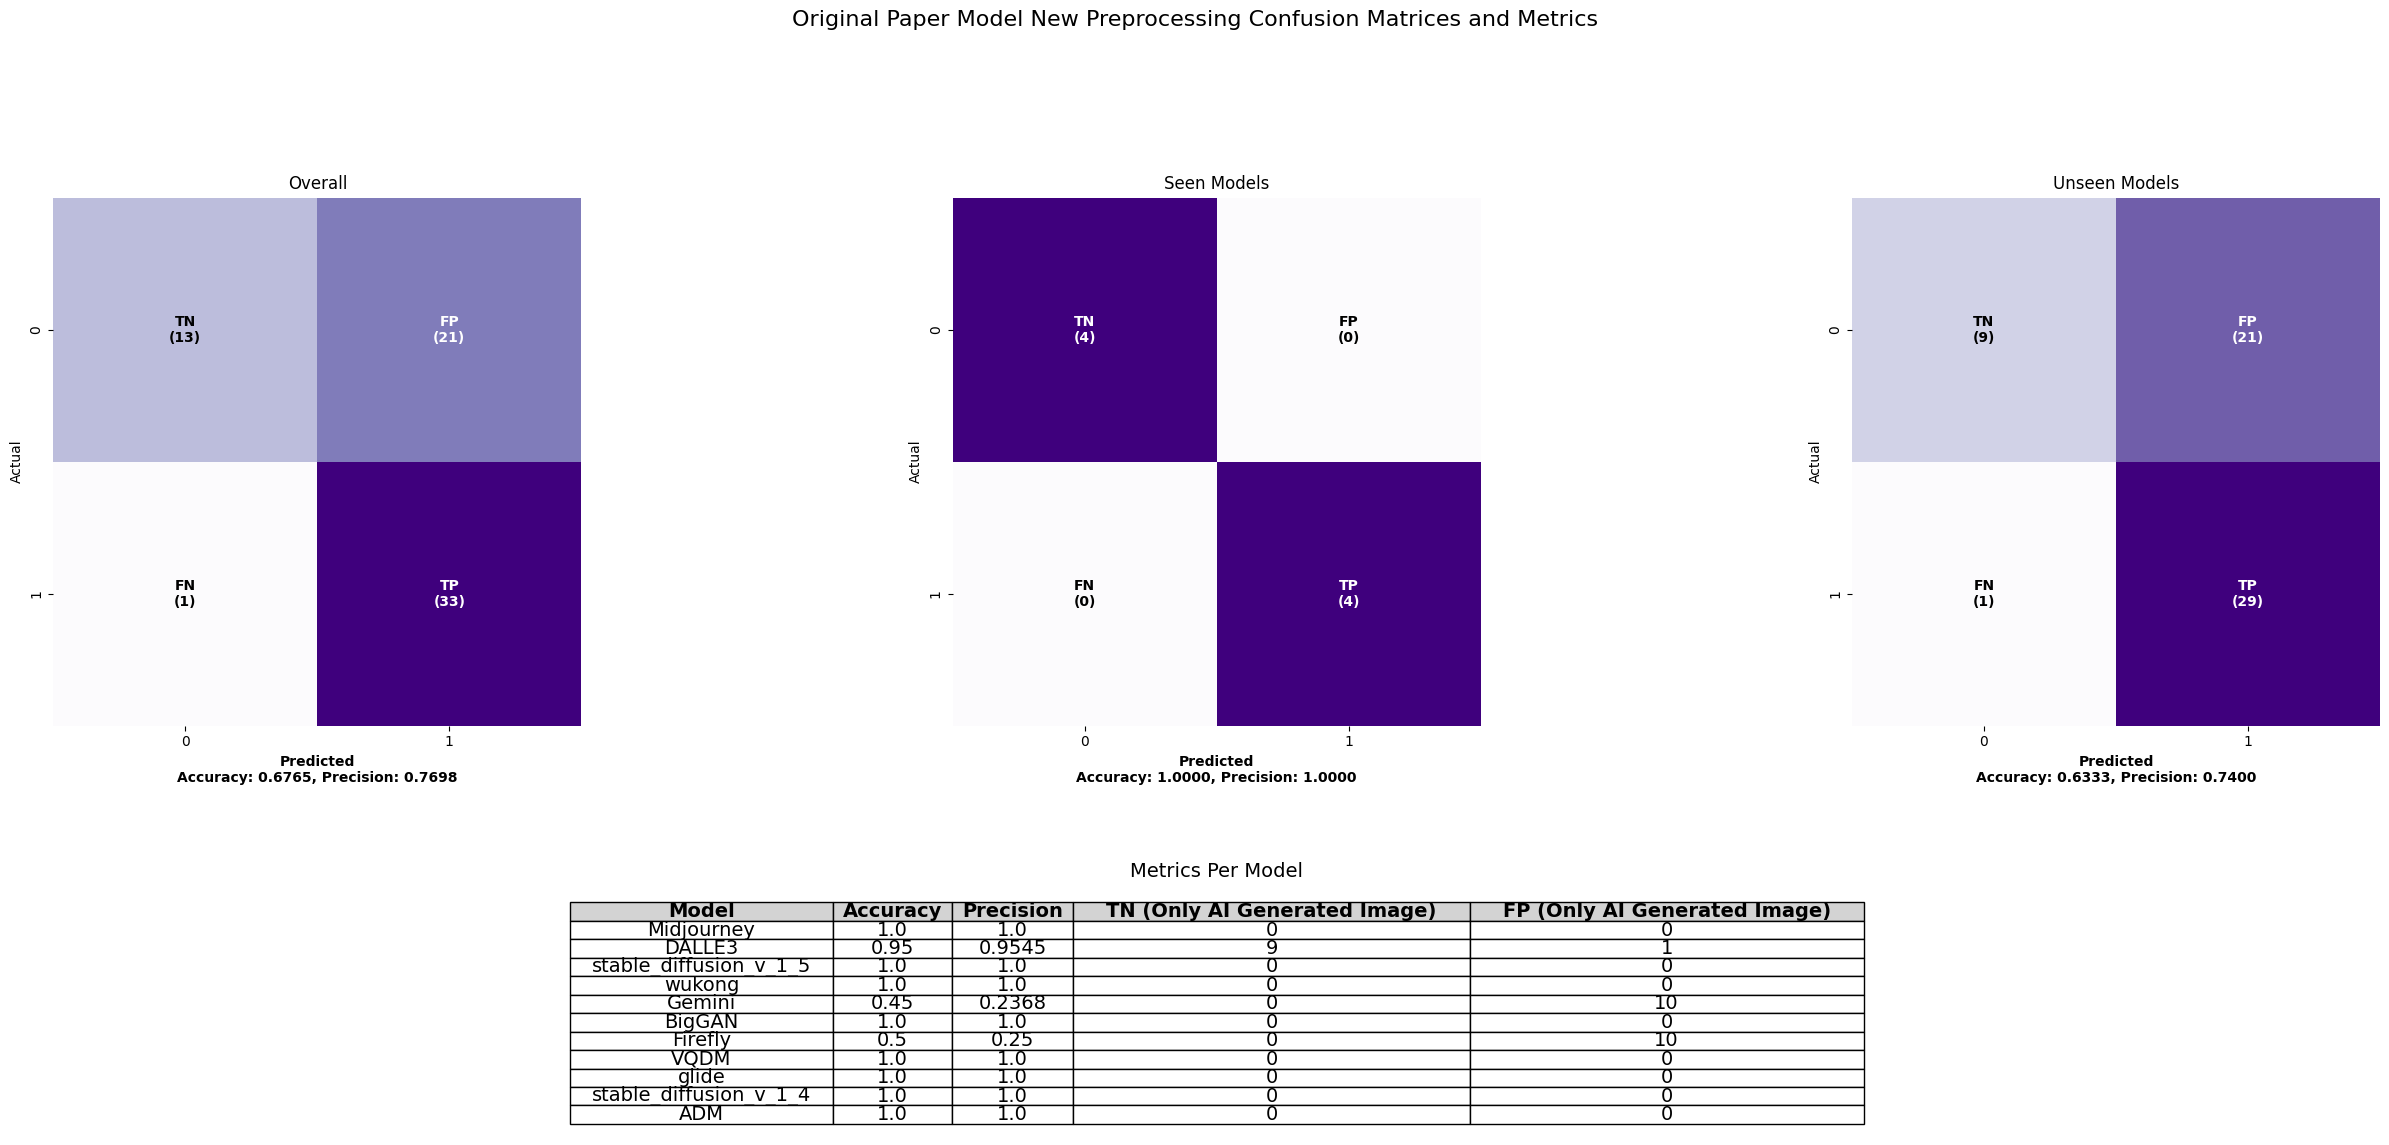

In [6]:
print("New Preprocessing")

ut.test(model_SWIN_MultiImage, test_loader_new_pre,
        device,"/home/kosta/code/School/SentryAI/pth/best_model_newPre_SWIN_frozen.pth",
        "Swin Transformer v2 New Preprocessing Frozen")
ut.test(model_SWIN_MultiImage, test_loader_new_pre,
        device,"/home/kosta/code/School/SentryAI/pth/best_model_newPre_SWIN_unfrozen.pth",
        "Swin Transformer v2 New Preprocessing UnFrozen")
ut.test(model_RESNET_MultiImage, test_loader_new_pre,
        device,"/home/kosta/code/School/SentryAI/pth/best_model_newPre_RESNET_frozen.pth",
        "Resnet New Preprocessing Frozen")
ut.test(model_RESNET_MultiImage, test_loader_new_pre,
        device,"/home/kosta/code/School/SentryAI/pth/best_model_newPre_RESNET_unfrozen.pth",
        "Resnet New Preprocessing UnFrozen")
ut.test(model_Original_MultiImage, test_loader_new_pre,
        device,"/home/kosta/code/School/SentryAI/pth/best_model_newPre_Base.pth",
        "Original Paper Model New Preprocessing")